<a href="https://colab.research.google.com/github/zahraDehghanian97/VoxelMorph_Registration/blob/master/VoxelMorph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Image Registration Using Voxelmorph
## Intelligent Analysis of Biomedical Images - Fall 2022
## Instructor: Dr. M. H. Rohban
## HW5 - Practical
## Student Name: Zahra Dehghanian
## Student ID: 401300417


In this assignment, you are going to train a voxelmorph network to do the unsupervised image registration task. You are going to use the [CHAOS MR T2 dataset](https://chaos.grand-challenge.org/), which is available to you from this google drive folder: [dataset](https://drive.google.com/drive/folders/1BGPa--fsmf8I5AeyFxa142N4lXpTqzIG?usp=sharing).
In this folder, you have access to 20 3D MR images of 20 different patients. Each image has its own number of slices (2D images) and consists of only one channel (gray-scaled images).

In the folder provided, you will have four different types of objects:


1.   the image itself
2.   the foreground mask (fgmask) of the image
3.   the label of the image
4.   the superpixels of the image

You have nothing to do with the superpixels; they are just in the folder. 



# Mount Drive
Mount your Google Drive here to get access to the data folder. If you don't know what is it and how to do it, use this [link](https://www.geeksforgeeks.org/download-anything-to-google-drive-using-google-colab/#:~:text=To%20import%20google%20drive%2C%20write,run%20it%20by%20Ctrl%2BEnter%20.&text=On%20running%20code%2C%20one%20blue,permission%20to%20access%20google%20drive.)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Installations

In [3]:
!pip install SimpleITK -q
!pip install sacred==0.7.5
!pip install voxelmorph -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 17.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 KB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 KB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=d834b8cce7f57832d1c88c27629652a9c41135029039dcbeab25fc7fa2491fd5
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
  Created wheel for jsonpickle: filename=jsonpickle-0.9.6-py3-none-any.whl size=29480 sha256=4b61560874f7600d917eabc7bd3e7764a6d22e8e119fa0c6a1dfa38e2a2d43dd
  Stored in directory: /root/.cache/pip/wheels/ab/e7/04/52ff0efc2d7898b2c830b2bbadb1c8a376303934593aaa3638
Successfully built docopt jsonpickle
     ━━━━━━━━━

# Imports

In [4]:
import os
import numpy as np
from matplotlib import pyplot as plt
import glob
from tqdm import tqdm
import torch
os.environ['VXM_BACKEND'] = 'pytorch'
import voxelmorph as vxm
from voxelmorph.torch.losses import NCC, MSE
import neurite as ne
import SimpleITK as sitk
import pickle
import json
import time
from voxelmorph.torch.losses import Dice

# Reading Data

In [5]:
class Patient:
    def __init__(self, id_):
        self.id = id_
        self.frames_count = None
        self.fgmasks = None
        self.images = None
        self.labels = None

    def remove_without_labels(self):
        idx = []
        for frame_number, label in enumerate(self.labels):
            if label.max() > 0:
                idx.append(frame_number)
        self.frames_count = len(idx)
        self.fgmasks = self.fgmasks[idx]
        self.images = self.images[idx]
        self.labels = self.labels[idx]

    def get_z_slice(self,z):
      idx = []
      for frame_number in range(z):
        idx.append(frame_number)
      
      return self.images[idx].astype('float')/(3.5*255)

    def print_data_shapes(self):
        print('patient ', self.id)
        print('fmgasks: ', self.fgmasks.shape)
        print('images: ', self.images.shape)
        print('lables: ', self.labels.shape)
        print('-' * 30)

    def plot(self, frame_number):
        fig , (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 15))
        ax1.imshow(self.images[frame_number], origin='lower', cmap='gray')
        ax2.imshow(self.fgmasks[frame_number], origin='lower', cmap='gray')
        ax3.imshow(self.labels[frame_number], origin='lower', cmap='gray')
        ax1.set_title("image")
        ax2.set_title("fgmask")
        ax3.set_title("lablel")


def create_patients(ids):
    patients = {}
    for id_ in ids:
        patients[id_] = Patient(id_)
    return patients


In [6]:
def save_patients_images(path):
    images = {}
    for id, patient in patients.items():
        images[id] = patient.images
    with open(path, 'wb') as f:
        pickle.dump(images, f)


def save_patients_superpixs(path):
    superpixs = {}
    for id, patient in patients.items():
        superpixs[id] = patient.superpixs
    with open(path, 'wb') as f:
        pickle.dump(superpixs, f)


def save_patients_labels(path):
    labels = {}
    for id, patient in patients.items():
        labels[id] = patient.labels
    with open(path, 'wb') as f:
        pickle.dump(labels, f)


def read_nii_bysitk(input_fid, peel_info=False):
    """ read nii to numpy through simpleitk
        peelinfo: taking direction, origin, spacing and metadata out
    """
    img_obj = sitk.ReadImage(input_fid)
    img_np = sitk.GetArrayFromImage(img_obj)
    if peel_info:
        info_obj = {
            "spacing": img_obj.GetSpacing(),
            "origin": img_obj.GetOrigin(),
            "direction": img_obj.GetDirection(),
            "array_size": img_np.shape
        }
        return img_np, info_obj
    else:
        return img_np

In [9]:
patient_ids = [1, 2, 3, 5, 8, 10, 13, 15, 19, 20, 21, 22, 31, 32, 33, 34, 36, 37, 38, 39]
project_root = "/content/gdrive/MyDrive/IABI-F2022/"
data_root = '/content/gdrive/MyDrive/IABI-F2022/chaos_MR_T2_normalized/'

patients = create_patients(patient_ids)
for path in tqdm(glob.iglob(data_root + '**/*.nii.gz', recursive=True), desc="Reading"):
    id_ = int(path.split('_')[-1].split('.')[0])
    patient = patients.get(id_)
    obj = read_nii_bysitk(path)
    if 'fgmask' in path:
        patient.fgmasks = obj
        patient.frames_count = obj.shape[0]
    elif 'image' in path:
        patient.images = obj
    elif 'label' in path:
        patient.labels = obj

Reading: 80it [01:30,  1.13s/it]


# Visualization

patient  1
fmgasks:  (37, 256, 256)
images:  (37, 256, 256)
lables:  (37, 256, 256)
------------------------------
patient  2
fmgasks:  (31, 256, 256)
images:  (31, 256, 256)
lables:  (31, 256, 256)
------------------------------
patient  3
fmgasks:  (36, 256, 256)
images:  (36, 256, 256)
lables:  (36, 256, 256)
------------------------------
patient  5
fmgasks:  (36, 256, 256)
images:  (36, 256, 256)
lables:  (36, 256, 256)
------------------------------
patient  8
fmgasks:  (34, 256, 256)
images:  (34, 256, 256)
lables:  (34, 256, 256)
------------------------------


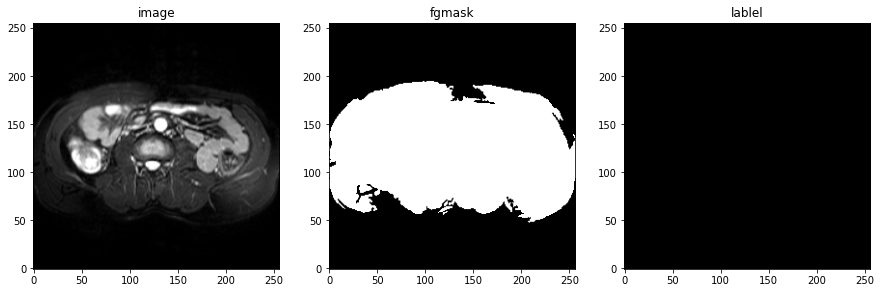

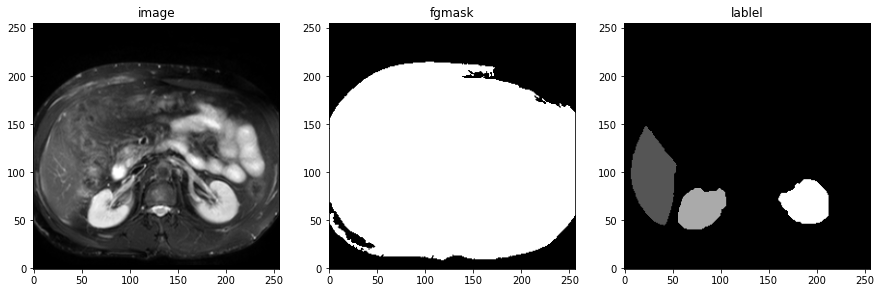

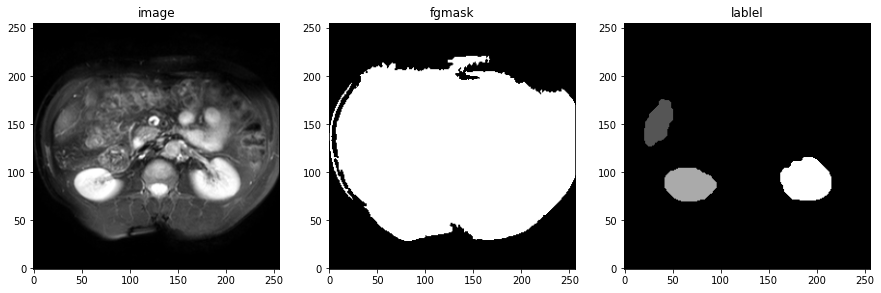

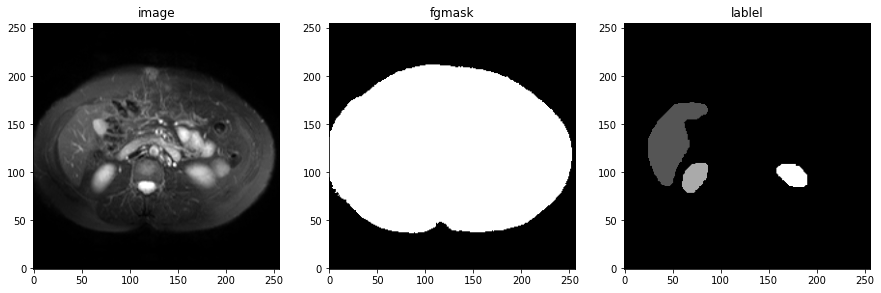

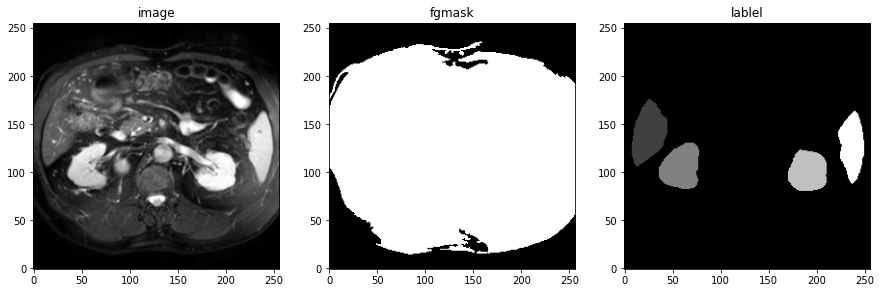

In [10]:
for i in sorted(list(patients.keys()))[:5]:
  patient = patients[i]
  patient.print_data_shapes()
  patient.plot(10)


# Trianing
In the following sections, you may read the data, get familiar with it, and implement a Pytorch code that trains a Voxelmorph network to register a moving image (2D) to a fixed image (also 2D). 




# Data Set and Data Loader

1.   Do your training with 19 images (all except the last one which has the ID 39; we need it for the testing part)

In [11]:
BATCH_SIZE = 20

In [15]:
train_data = []
val_data = []
test_data = []

for i in range(len(patient_ids)):
  patient = patients[patient_ids[i]]
  for j in range(patient.frames_count):
    if i < 18 :
      train_data.append(patient.images[j])
    elif i == 18:
      val_data.append(patient.images[j])
    else : 
      test_data.append(patient.images[j])

train_data = np.stack(train_data)
val_data = np.stack(val_data)
test_data = np.stack(test_data)

train_data.shape, val_data.shape, test_data.shape

((647, 256, 256), (40, 256, 256), (31, 256, 256))

2.   You have to train your network in an unsupervised manner (don't use labels in training)

In [31]:
class vxm_data_loader:

  def __init__(self, data, batch_size):
    self.data = data
    self.batch_size = batch_size
    self.idx = []
    for i in range(1, len(self.data)):
      self.idx.append((i-1,i))
    
  def load(self):
    idx = np.random.permutation(self.idx)
    batch_source = []
    batch_target = []
    iter = 0
    for n, (i, j) in enumerate(idx):
      batch_source.append(torch.tensor(self.data[i], dtype=torch.float32))
      batch_target.append(torch.tensor(self.data[j], dtype=torch.float32))
      if (n + 1) % self.batch_size == 0:
        yield torch.stack(batch_source).unsqueeze(1), torch.stack(batch_target).unsqueeze(1)
        batch_source = []
        batch_target = []
  

In [32]:
train_dataloader = vxm_data_loader(train_data, batch_size=BATCH_SIZE)
val_dataloader = vxm_data_loader(val_data, batch_size=BATCH_SIZE)
test_dataloader = vxm_data_loader(test_data, batch_size=BATCH_SIZE)

loaders = {'train': train_dataloader,'val': val_dataloader,'test': test_dataloader}

# Data Loader Visualization

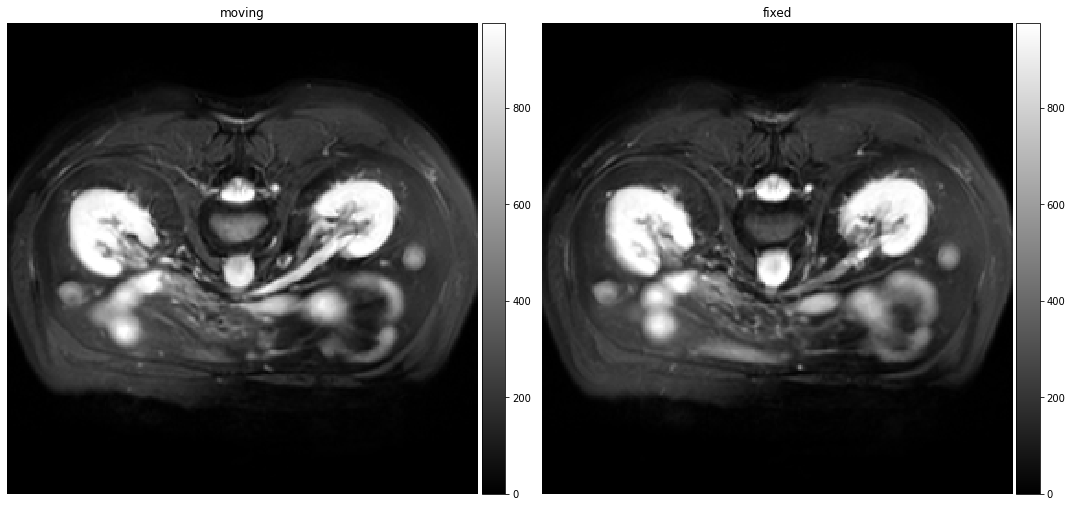

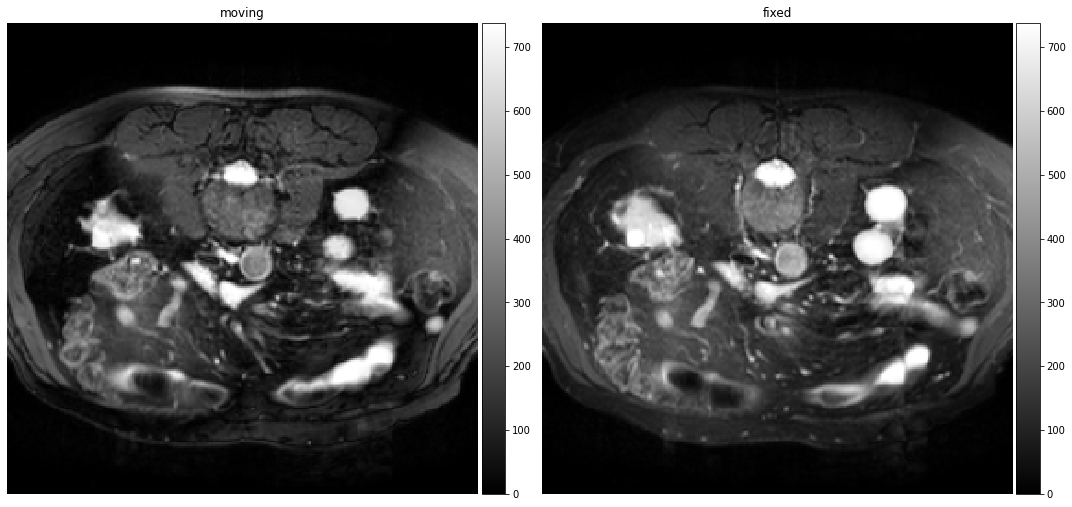

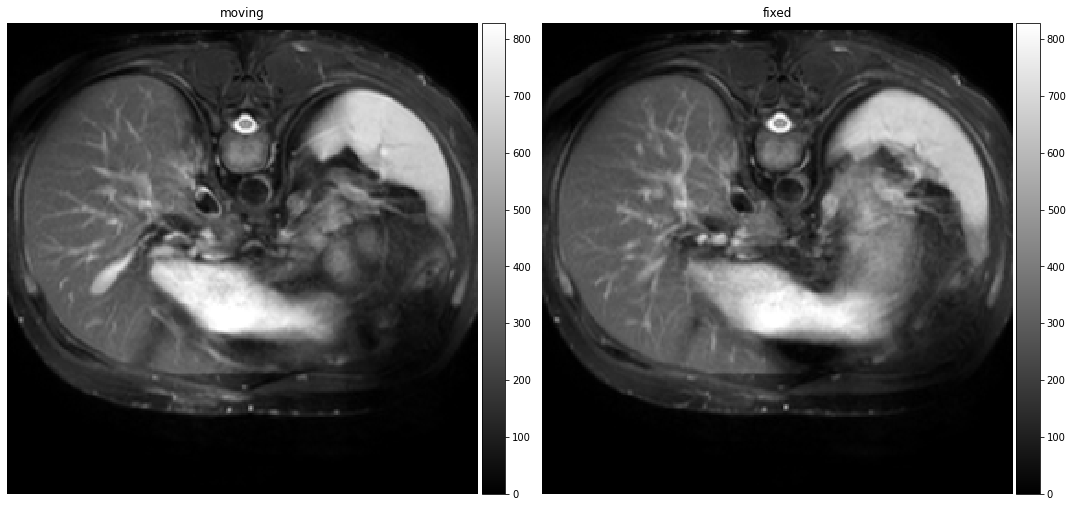

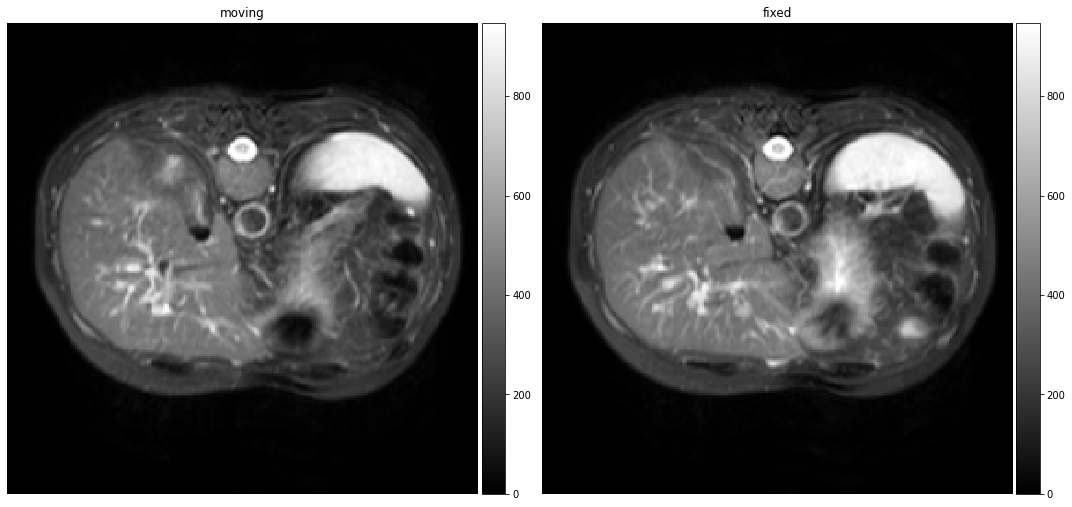

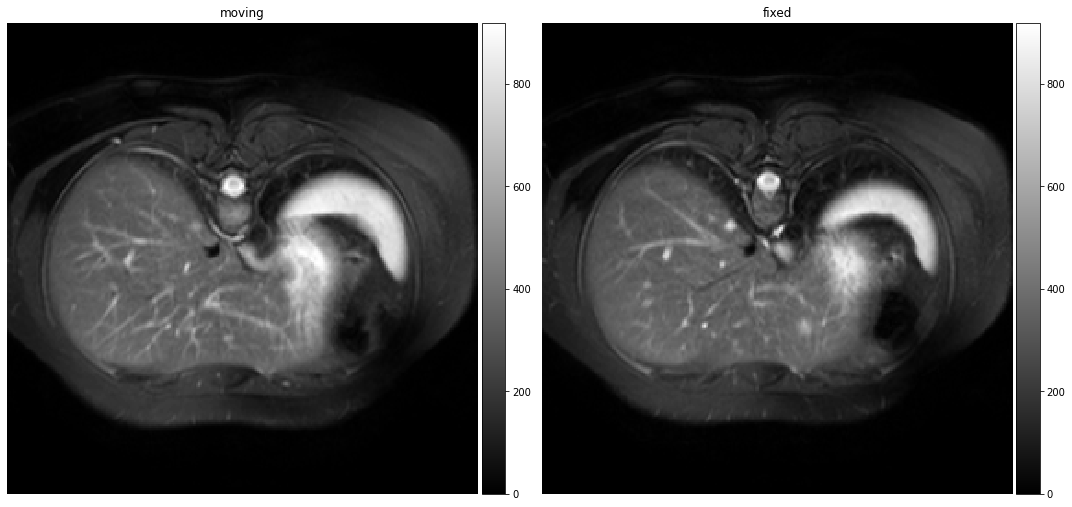

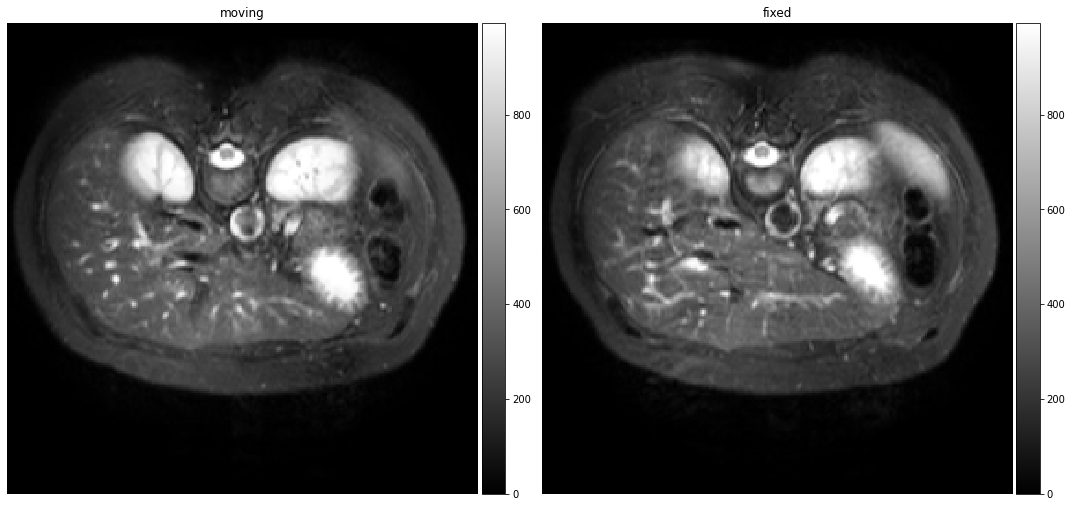

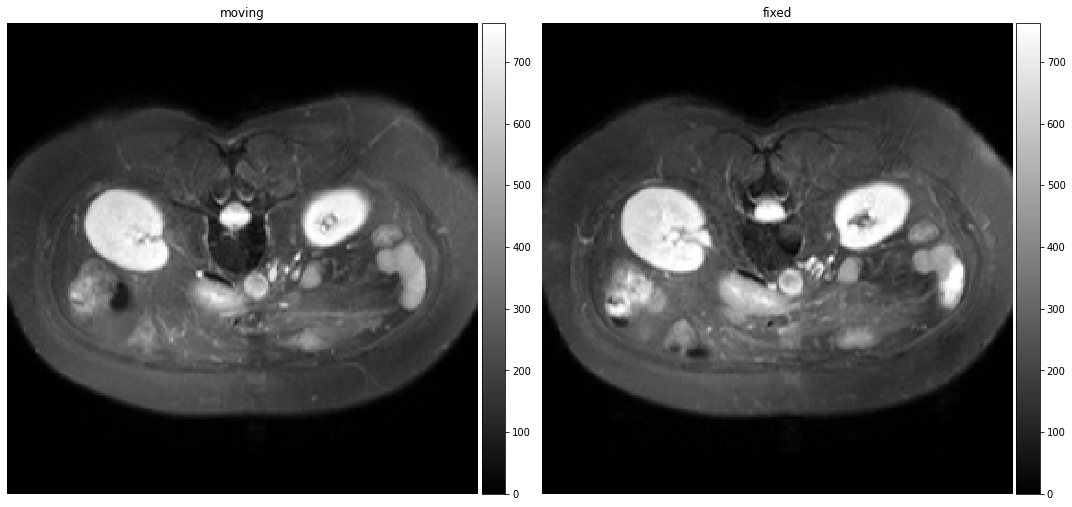

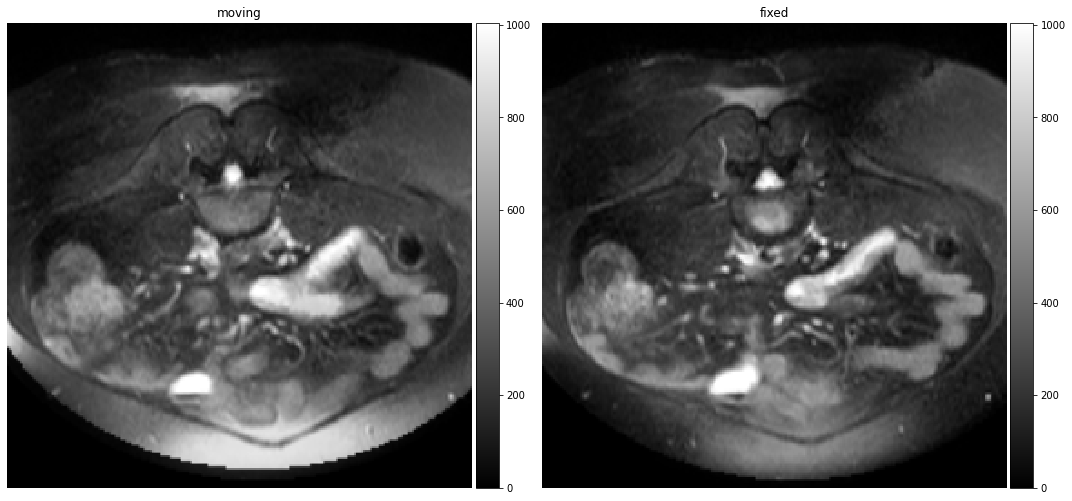

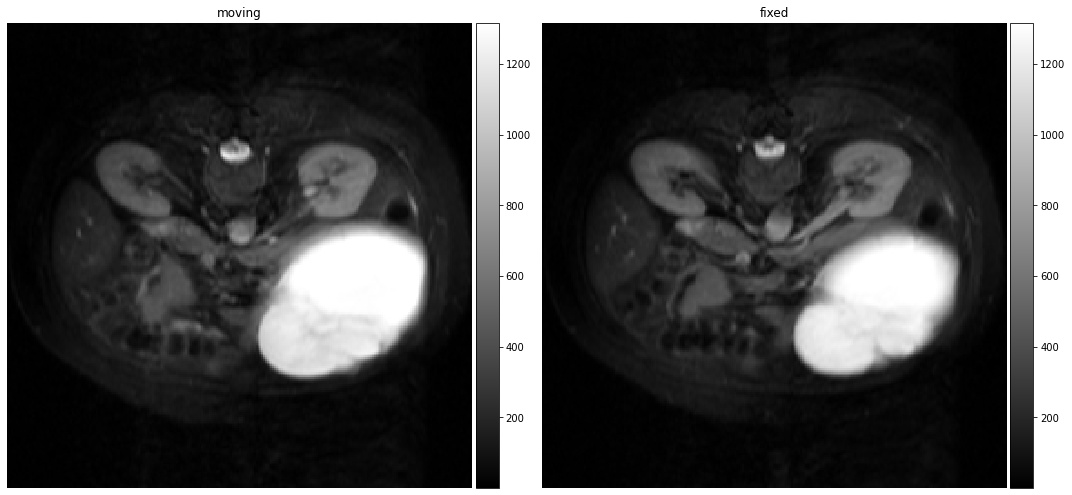

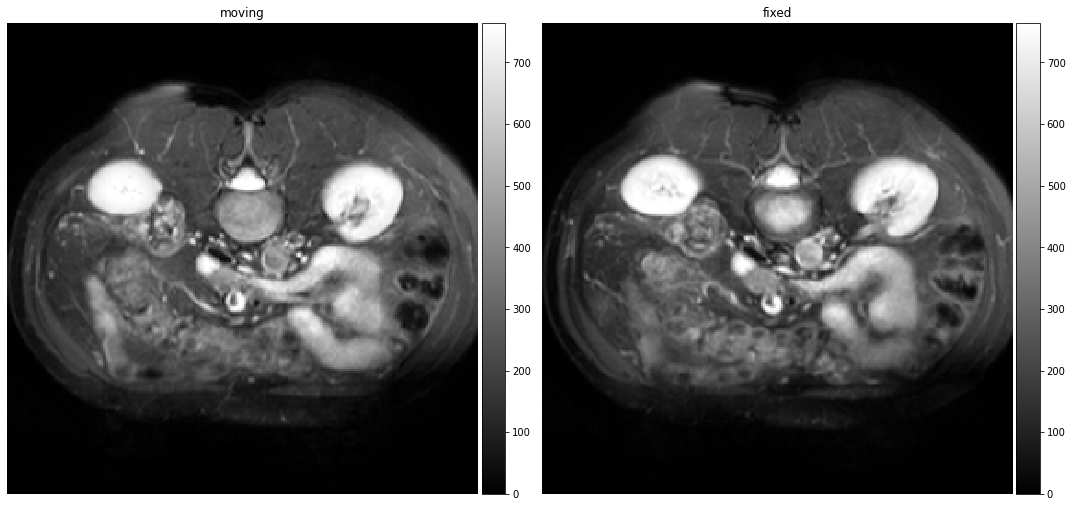

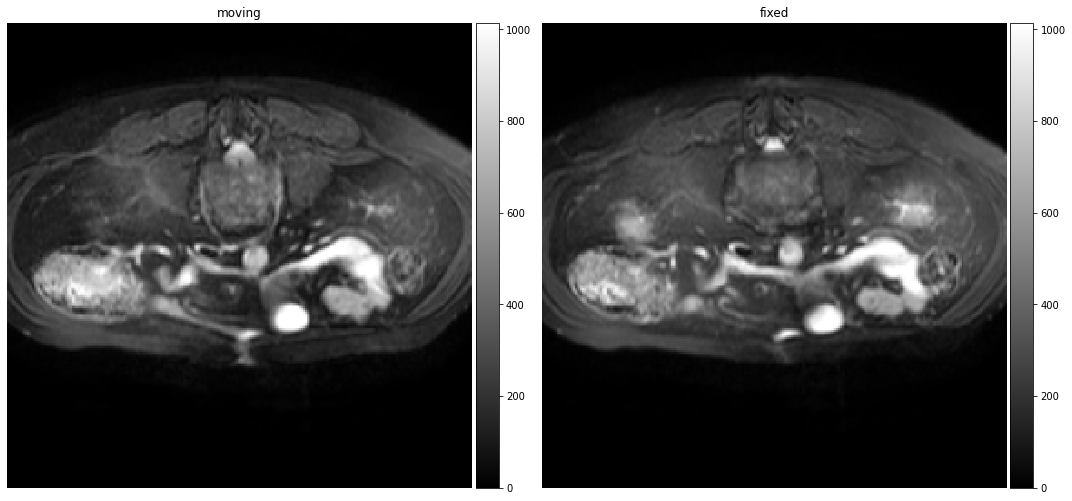

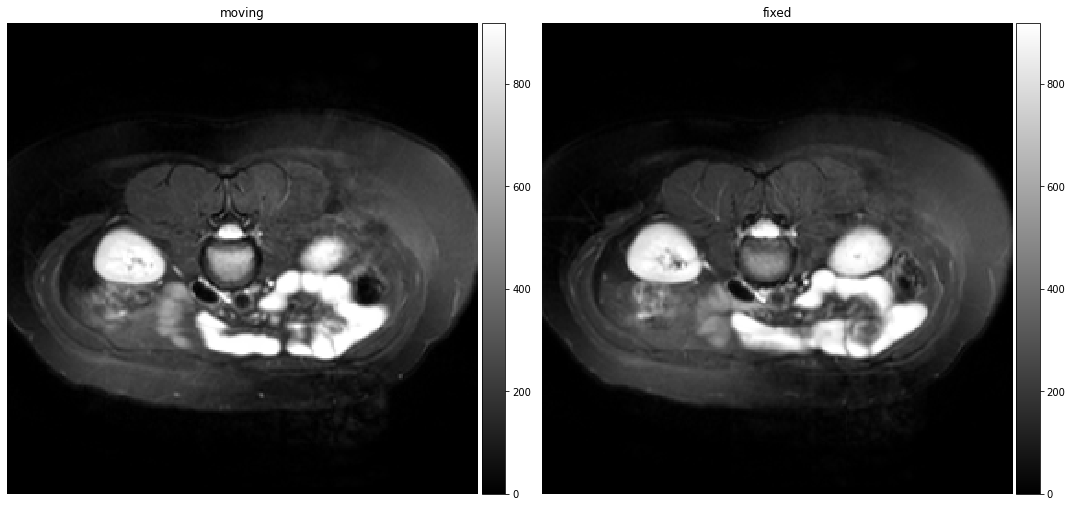

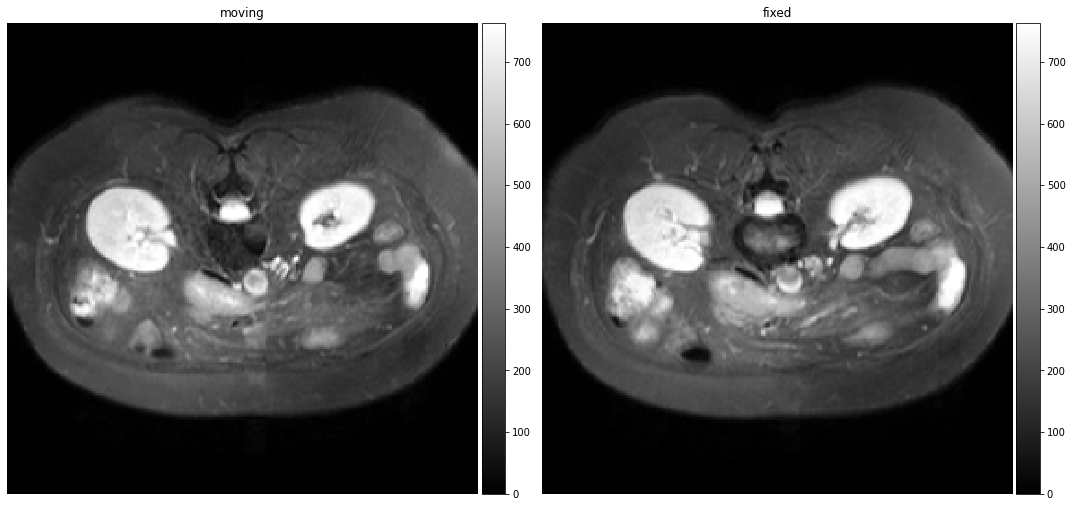

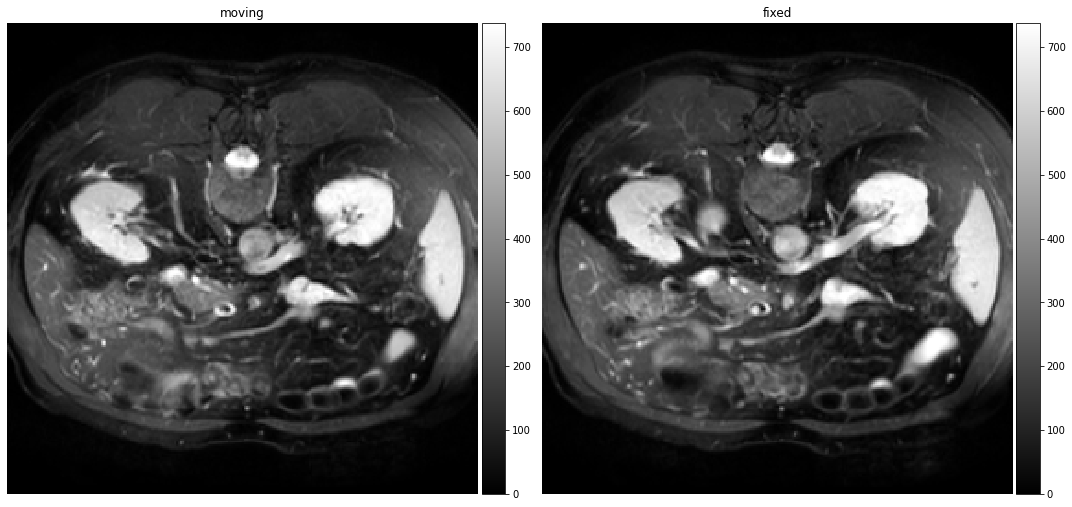

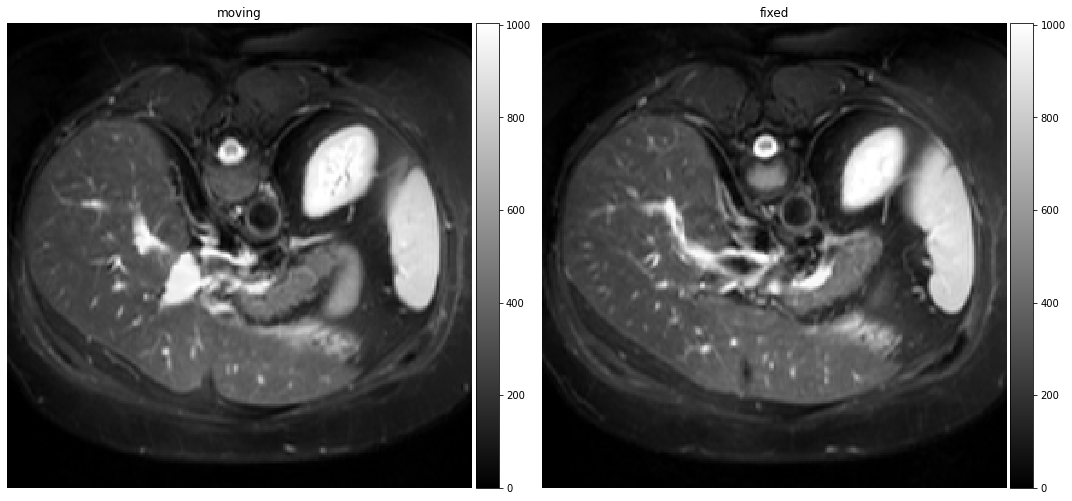

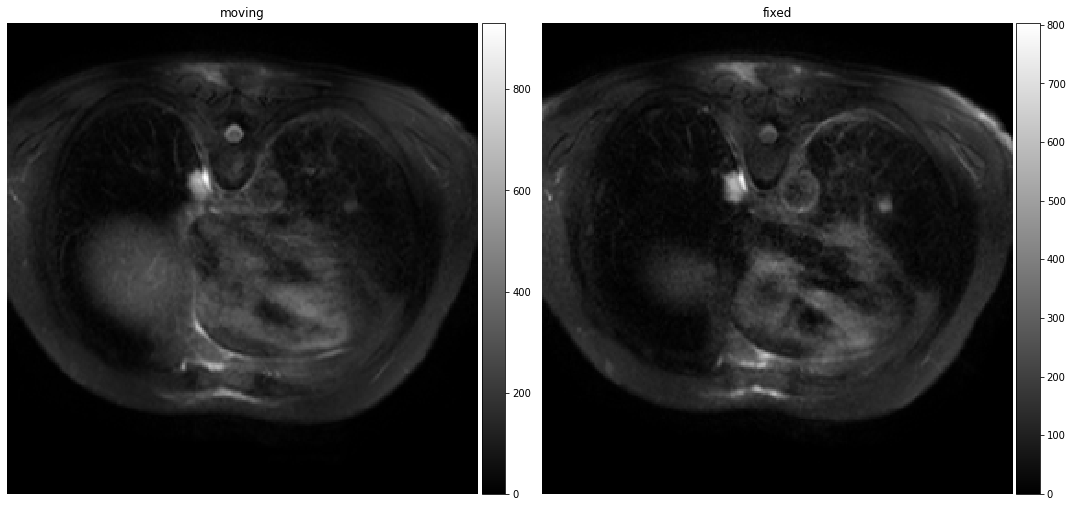

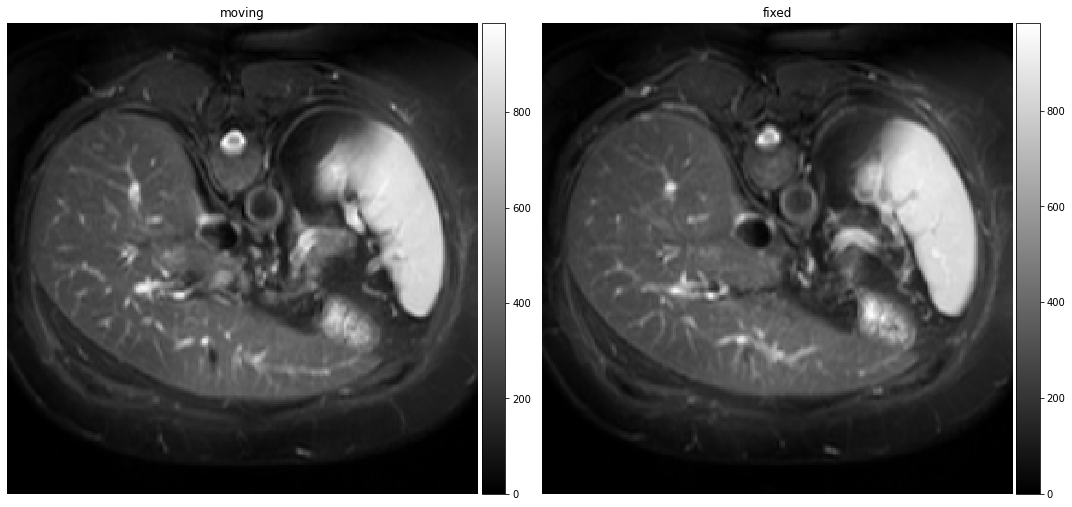

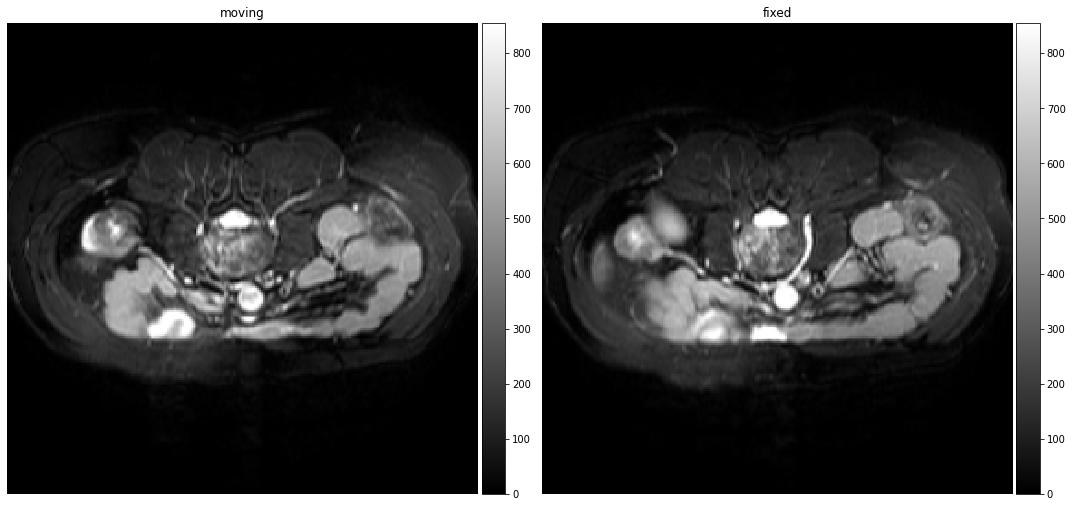

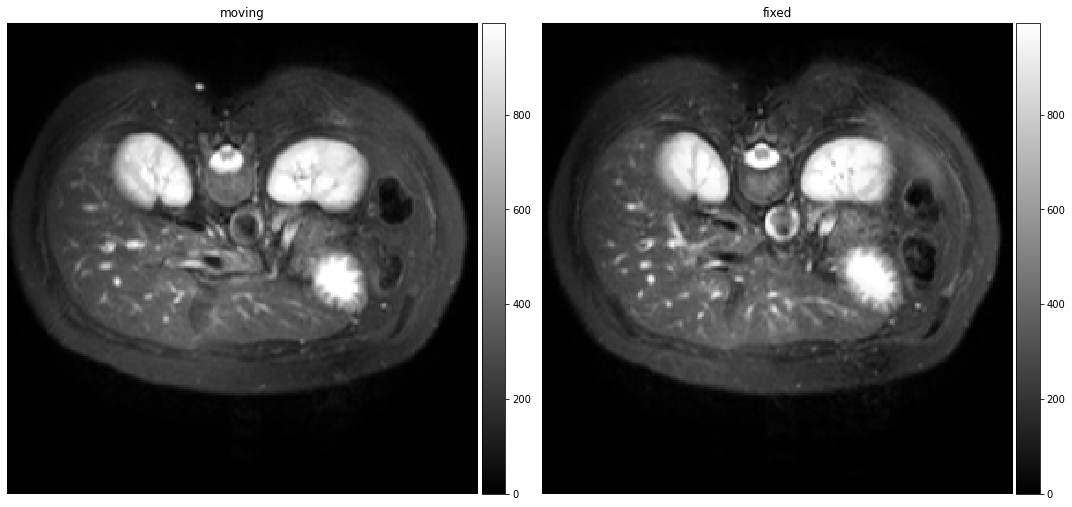

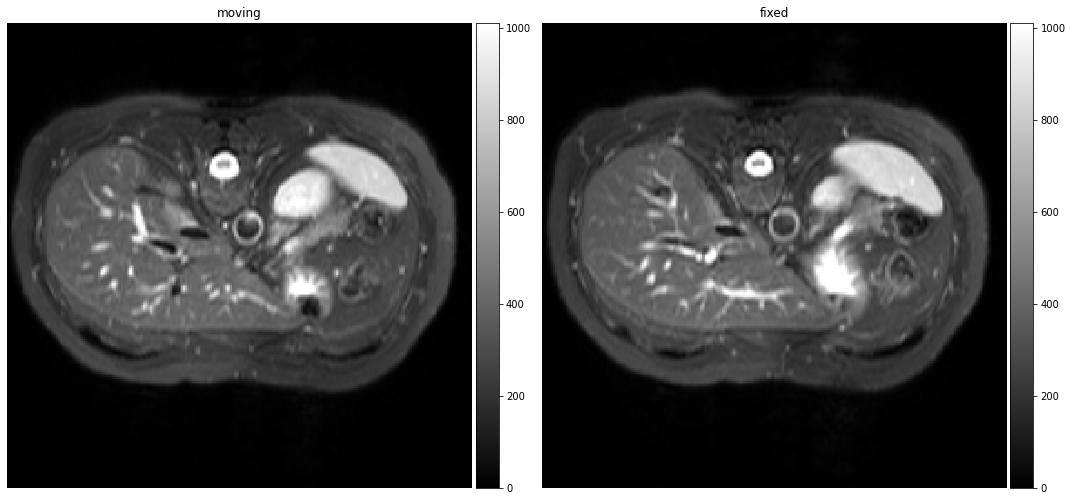

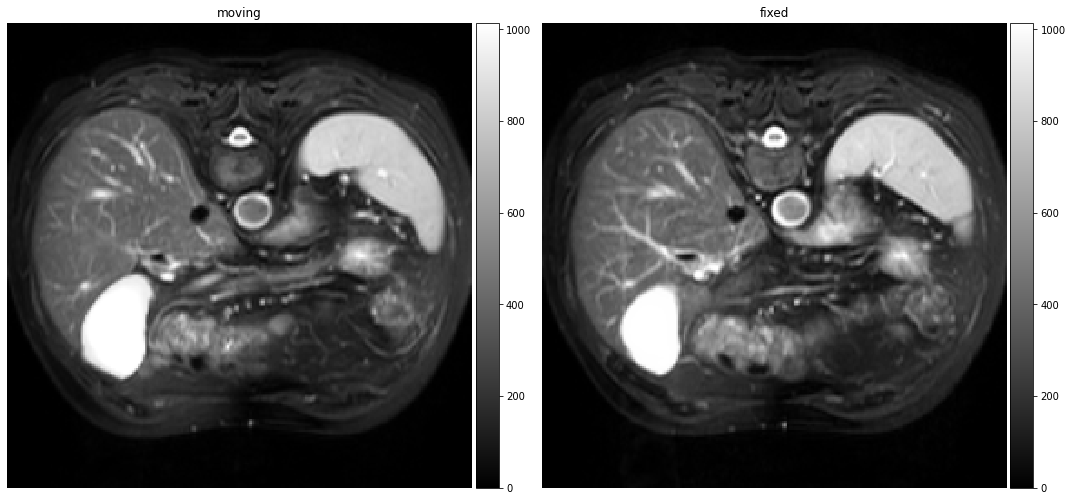

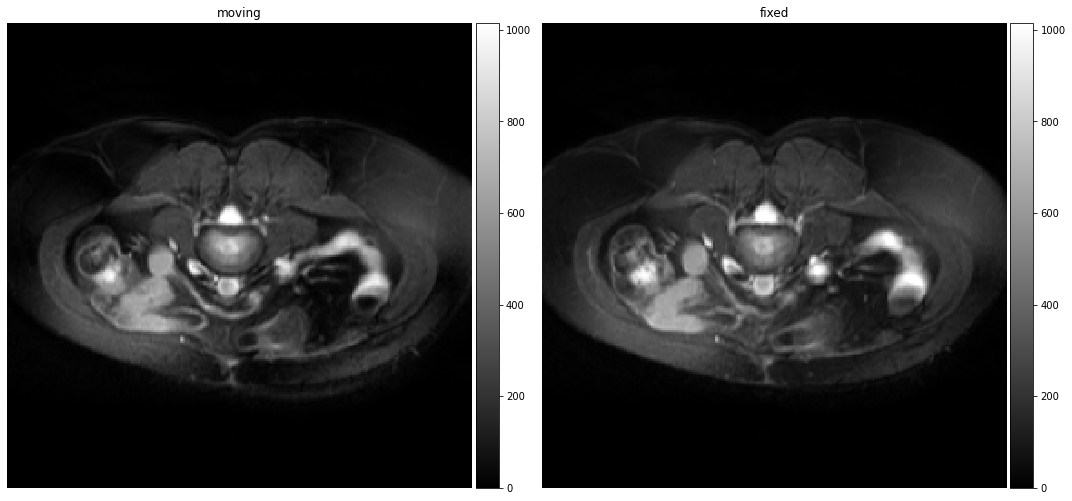

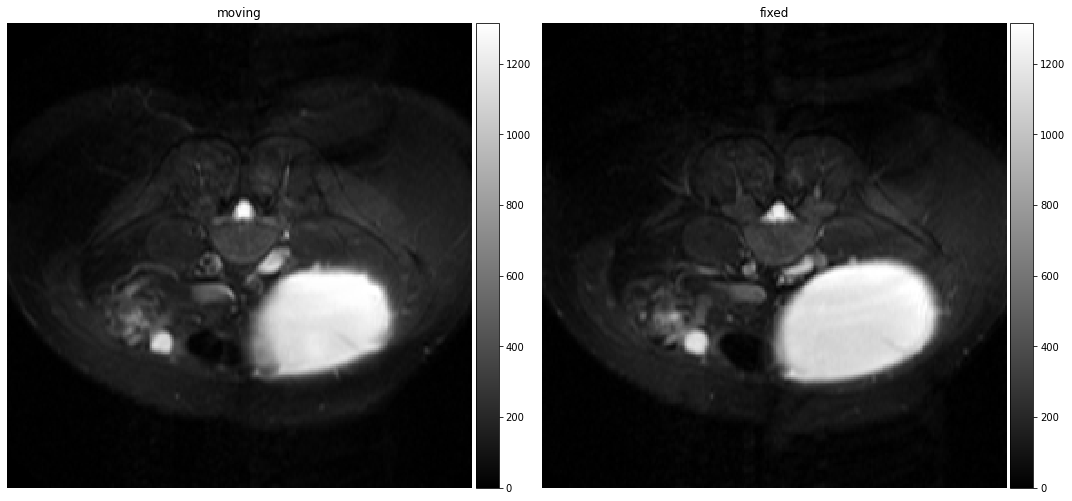

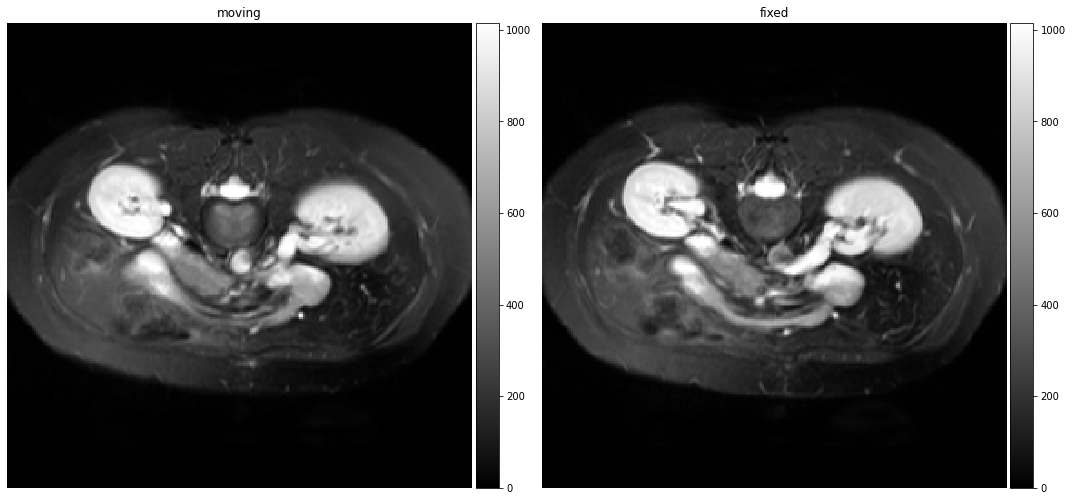

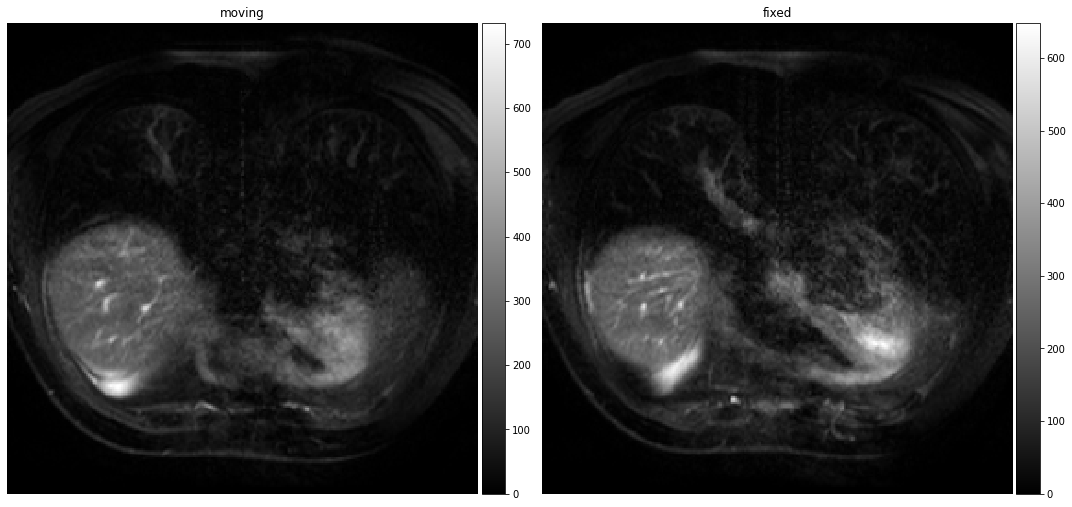

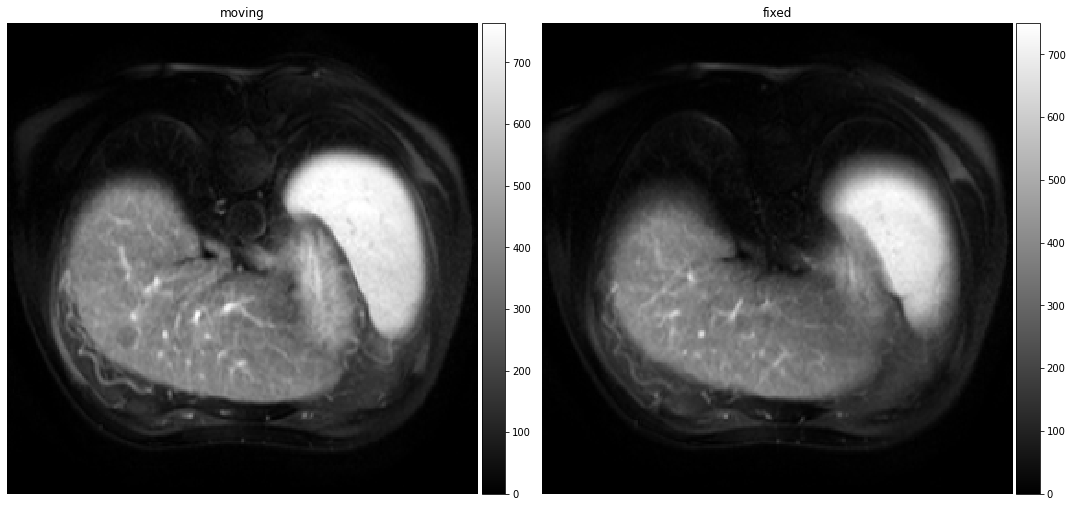

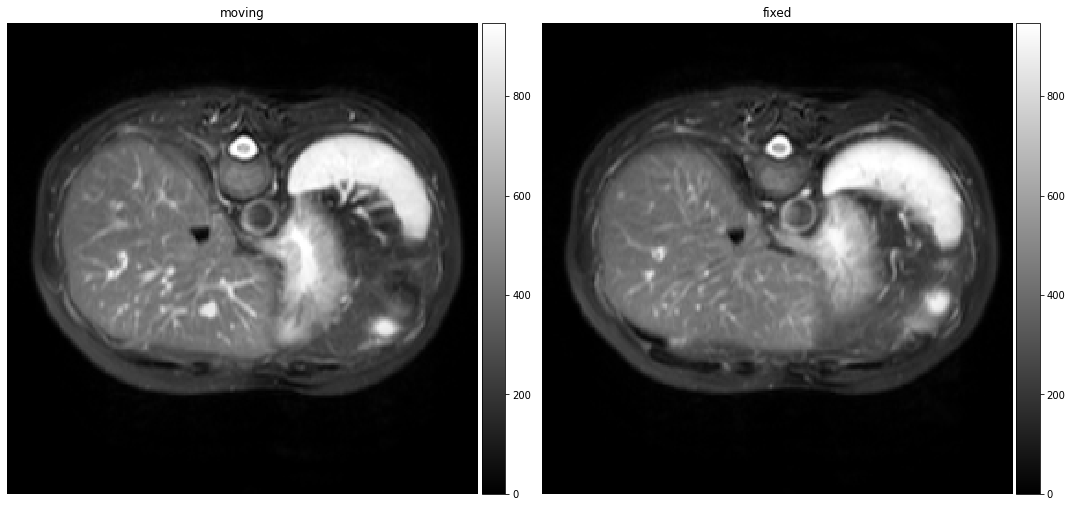

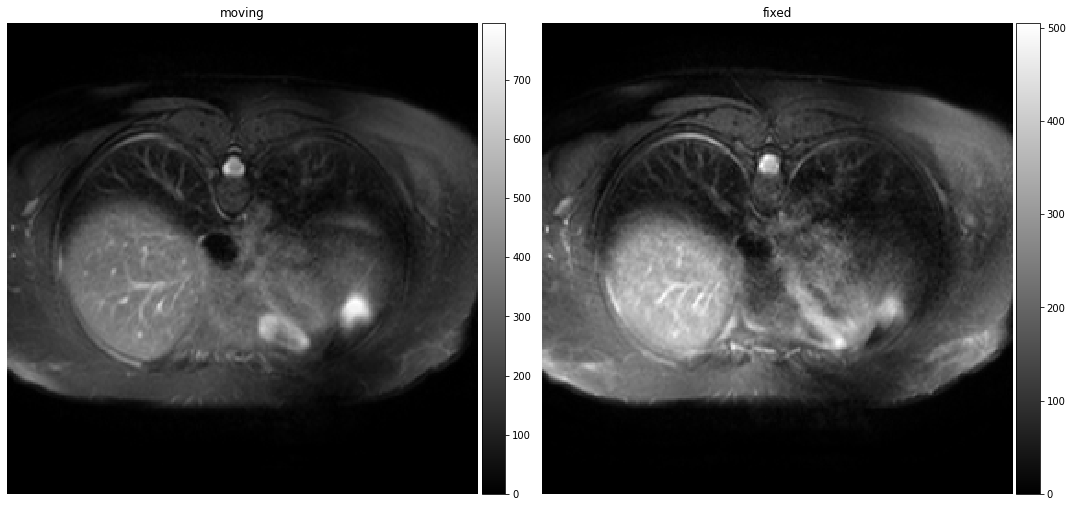

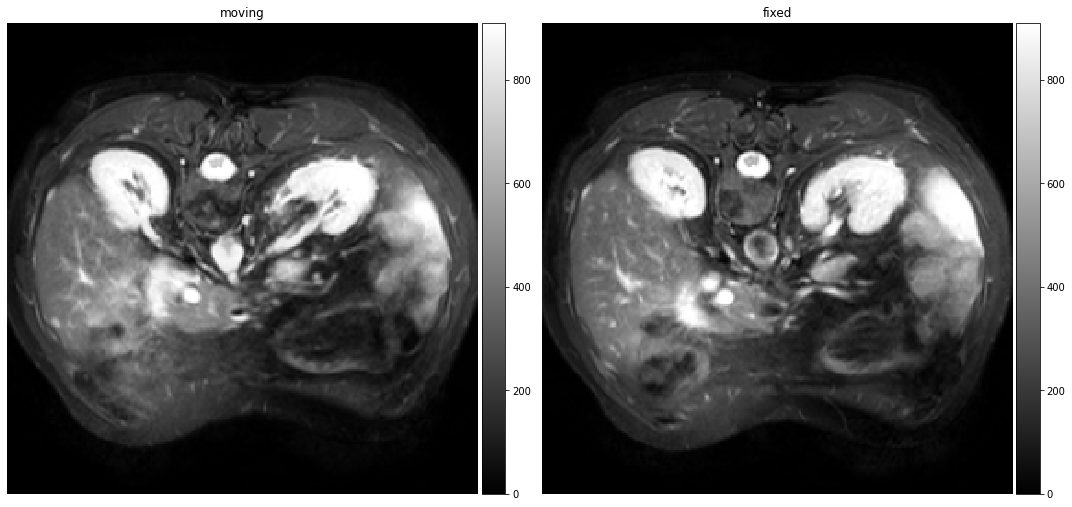

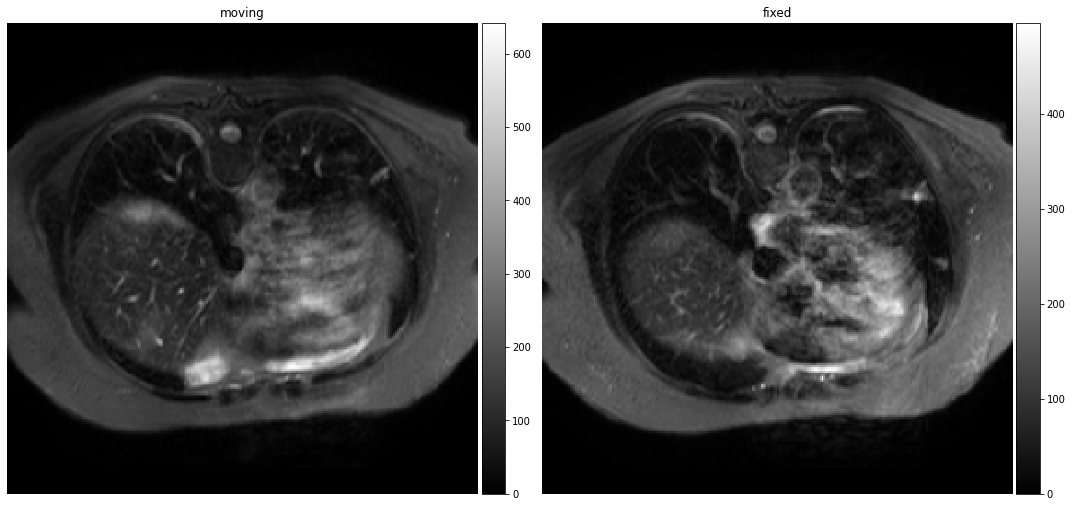

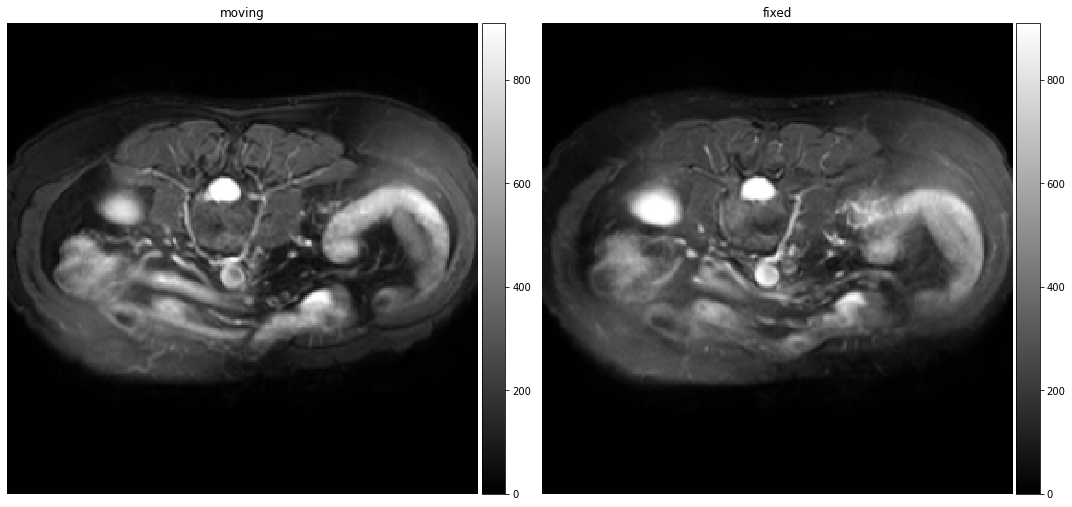

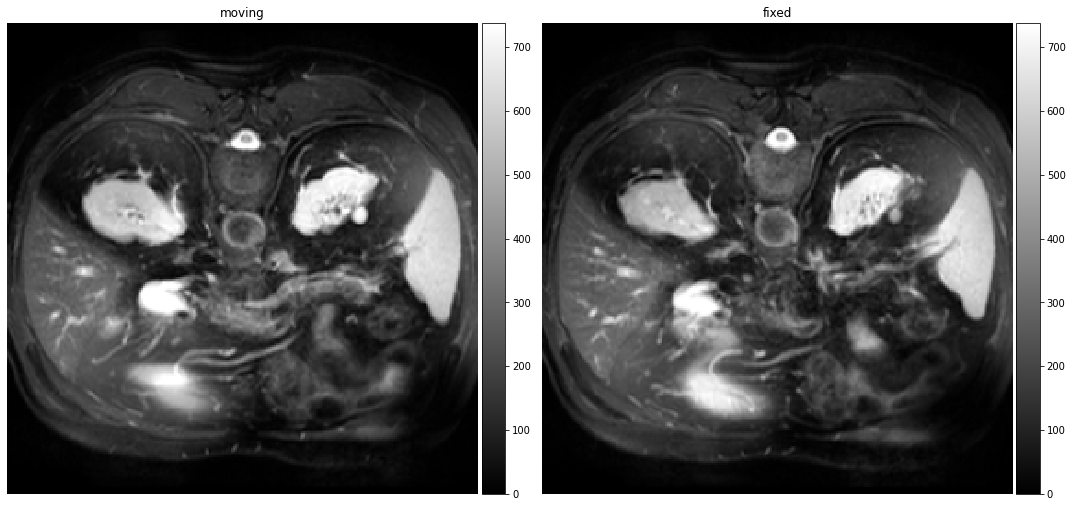

In [33]:
for input, output in train_dataloader.load():
  ne.plot.slices([input[0], output[0]], titles=['moving', 'fixed'], cmaps=['gray'], do_colorbars=True)

# Volxelmorph


3.   Use voxelmorph library; you don't need to implement the model yourself


In [177]:
in_shape = patients[1].images[0].shape
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
vxm_model = vxm.networks.VxmDense(in_shape, nb_unet_features=[[16, 32, 64, 96], [96, 64, 32, 16]], bidir=True, int_steps=0)
_ = vxm_model.to(device)

# Loss and Optimizer

4.   Use both similarity and smoothness losses. You may use trial and error to determine the best combination of these losses.

In [178]:
class ND_Grad:

    def __init__(self, penalty='l2'):
      self.penalty = penalty

    def loss(self, _, y_pred):
      dy = torch.abs(y_pred[:,:,1:,:] - y_pred[:,:,:-1,:])
      dx = torch.abs(y_pred[:,:,:,1:] - y_pred[:,:,:,:-1])
      if self.penalty == 'l2':
          dy = dy * dy
          dx = dx * dx
      d = torch.mean(dx) + torch.mean(dy)
      grad = d / 2.0
      return grad

In [179]:
lambda_param = 0.01
dice_param = 0.001
loss_weights = [1,dice_param, lambda_param]
losses = {'dice': Dice().loss, 'mse': MSE().loss , 'grad': ND_Grad().loss}

In [180]:
optimizer = torch.optim.Adam(vxm_model.parameters(), lr=1e-4, weight_decay=1e-4)

Training

In [181]:
nb_epochs = 40
best_validation_loss = 10000
modes = ['train', 'val']
training_loss = {k: [] for k in modes}

for epoch in range(nb_epochs):
  print(f' Epoch {epoch} '+'>'*20)
  for mode in modes:
    loss = 0
    c = 0
    if mode == 'train':
      vxm_model.train()
    else:
      vxm_model.eval()
    for source, target in loaders[mode].load():
      source = source.to(device)
      target = source.to(device)
      with torch.set_grad_enabled(mode == 'train'):
        if mode == 'train':
          optimizer.zero_grad()
        moved_source, field = vxm_model(source, target, registration=True)
        mse_loss = losses['mse'](moved_source, target)
        dice_loss = losses['dice'](moved_source, target)
        smoothness_loss = losses['grad'](_, field)
        loss = loss_weights[0] * mse_loss + loss_weights[1] * dice_loss + loss_weights[2] * smoothness_loss
        batch_size = len(source) 
        loss += loss.item() * batch_size
        c += batch_size
        if mode == 'train':
          loss.backward()
          optimizer.step()
    if mode == 'val' and loss / c < best_validation_loss:
      best_validation_loss = loss
      torch.save(vxm_model.state_dict(), 'model.pth')
    print(f'{mode} phase :   Loss = {loss / c}')
    training_loss[mode].append(loss / c)
    
print("Training Finished Succesfully !!!!")


 Epoch 0 >>>>>>>>>>>>>>>>>>>>
train phase :   Loss = 2.7259397506713867
val phase :   Loss = 112.47293853759766
 Epoch 1 >>>>>>>>>>>>>>>>>>>>
train phase :   Loss = 0.3506644666194916
val phase :   Loss = 5.976351737976074
 Epoch 2 >>>>>>>>>>>>>>>>>>>>
train phase :   Loss = 0.0296173132956028
val phase :   Loss = 1.115102767944336
 Epoch 3 >>>>>>>>>>>>>>>>>>>>
train phase :   Loss = 0.014838422648608685
val phase :   Loss = 0.5557450652122498
 Epoch 4 >>>>>>>>>>>>>>>>>>>>
train phase :   Loss = 0.01097166445106268
val phase :   Loss = 0.33516725897789
 Epoch 5 >>>>>>>>>>>>>>>>>>>>
train phase :   Loss = 0.006801806390285492
val phase :   Loss = 0.19073127210140228
 Epoch 6 >>>>>>>>>>>>>>>>>>>>
train phase :   Loss = 0.005040145944803953
val phase :   Loss = 0.16034193336963654
 Epoch 7 >>>>>>>>>>>>>>>>>>>>
train phase :   Loss = 0.0032333009876310825
val phase :   Loss = 0.1142878457903862
 Epoch 8 >>>>>>>>>>>>>>>>>>>>
train phase :   Loss = 0.0023266428615897894
val phase :   Loss = 


5. Plot the training loss  


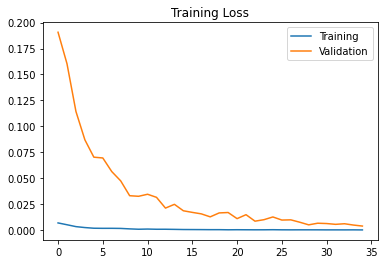

In [194]:
plt.plot([float(item.cpu().detach().numpy()) for item in training_loss['train'][5:]], label = 'Training')
plt.plot([float(item.cpu().detach().numpy()) for item in training_loss['val'][5:]], label = 'Validation')
plt.title('Training Loss')
plt.legend()
plt.show()

6. Visualize your model's ability to register images by plotting at least 10 (moving, moved, fixed) triplets


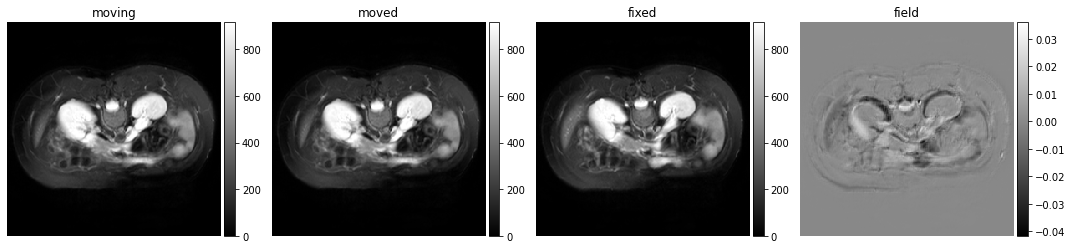

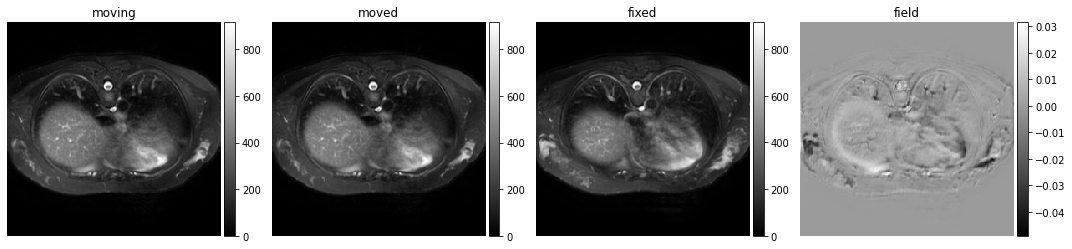

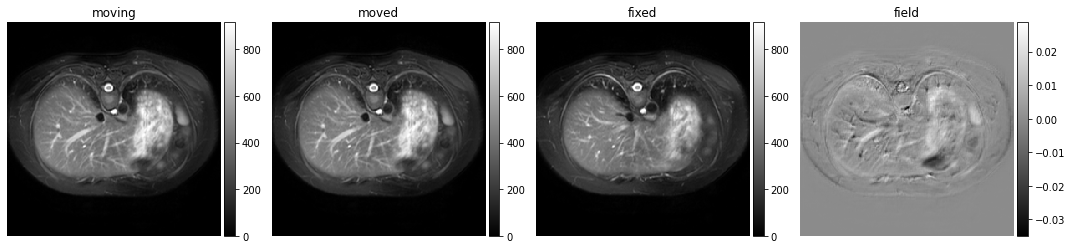

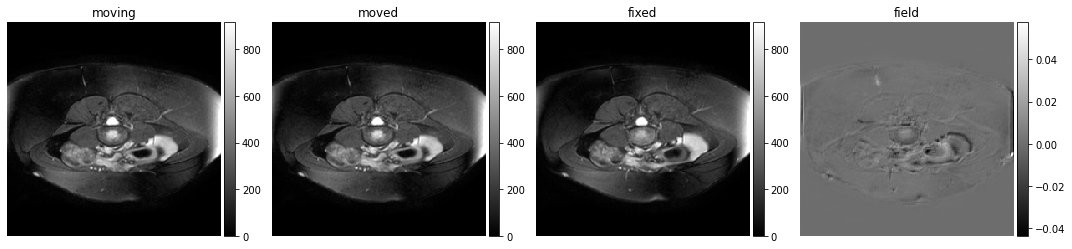

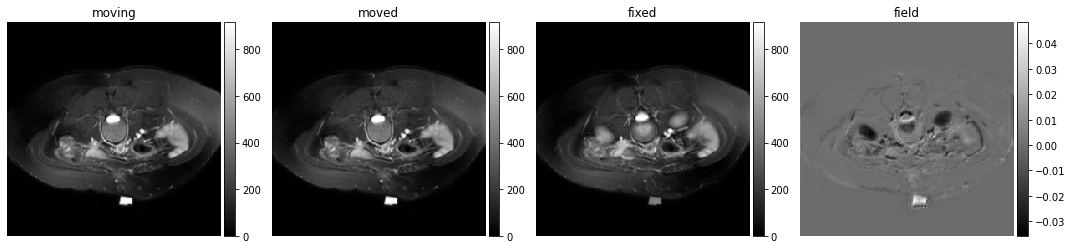

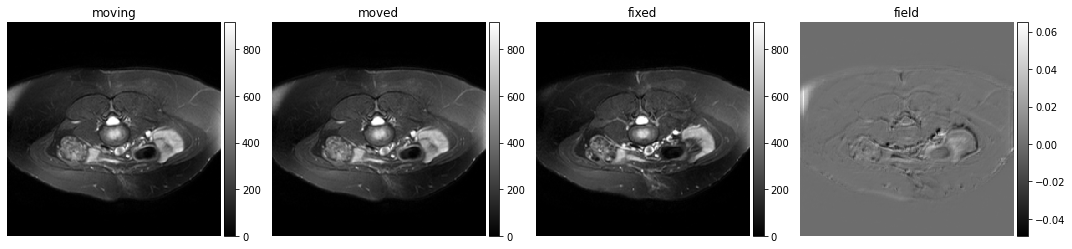

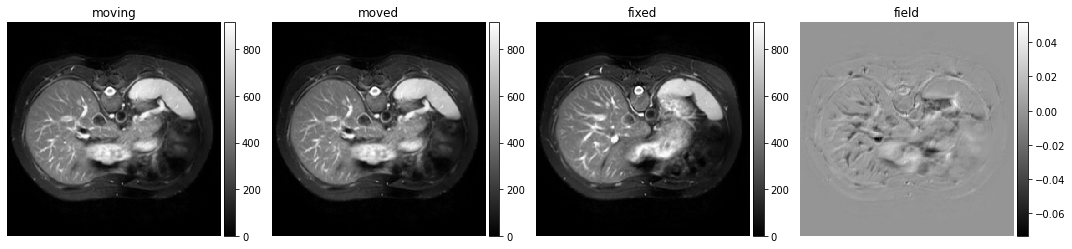

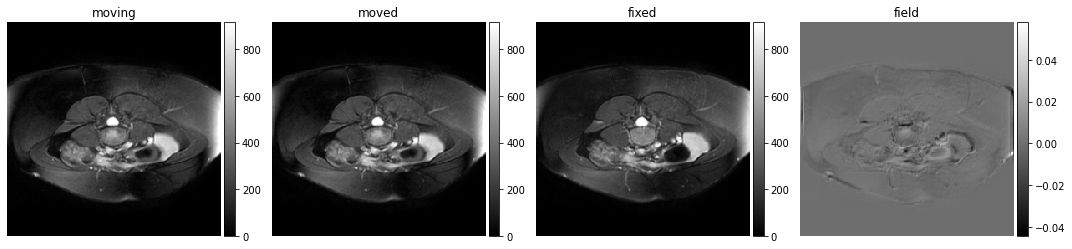

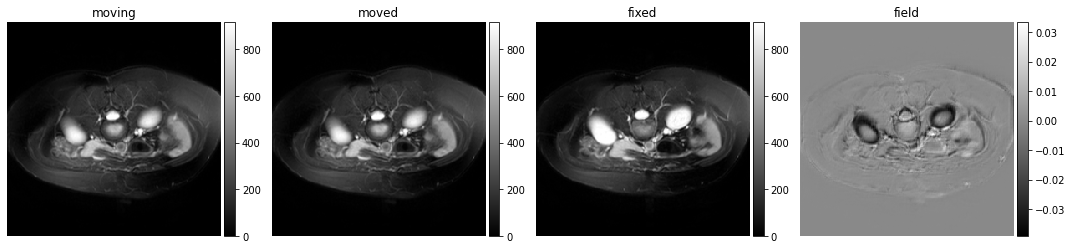

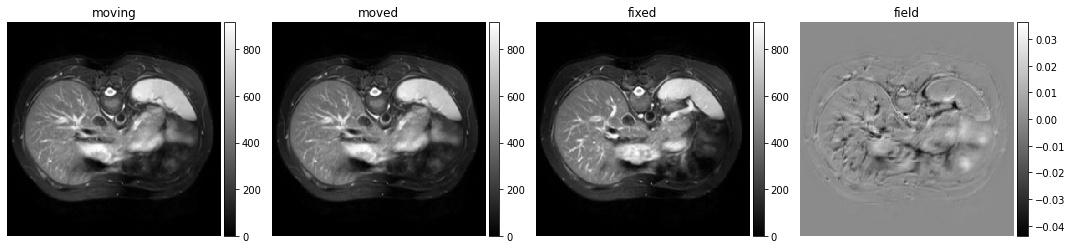

In [183]:
vxm_model.eval()
for source, target in val_dataloader.load():
  with torch.no_grad():
    source = source.to(device)
    target = target.to(device)
    output, field = vxm_model(source, target, registration=True)
  idx = list(np.random.choice(BATCH_SIZE, size=10, replace=False))
  moving = source[idx].squeeze().cpu().numpy()
  moved = output[idx].squeeze().cpu().numpy()
  fixed = target[idx].squeeze().cpu().numpy()
  field = torch.sum(field[idx].squeeze(), dim=1).cpu().numpy()
  for i in range(10):
    ne.plot.slices([moving[i], moved[i], fixed[i], field[i]], titles=['moving', 'moved', 'fixed', 'field'], cmaps=['gray'], do_colorbars=True)

6.   You may use creative approaches to improve your results (e.g., train bidirectional, train with not adjacent slices, etc.)


In [184]:
# use dice score in loss function
# train bidirectional

# Testing

1.   Pick the patient 39 image and label
2.   Find the range of slices in which all slices have a labeled organ (slices whose label is not blank)





In [185]:
test_patient = patients[patient_ids[-1]]
test_patient.remove_without_labels()
len(test_patient.images)

26

3.   Pick the middle slice in the range mentioned above



In [186]:
chosen_slice = (len(test_patient.images))//2
targets = torch.tensor(test_patient.images, dtype=torch.float32).unsqueeze(1)
source = torch.tensor(test_patient.images[chosen_slice], dtype=torch.float32).unsqueeze(0).unsqueeze(1).repeat(len(targets), 1, 1, 1)
source.shape, targets.shape

(torch.Size([26, 1, 256, 256]), torch.Size([26, 1, 256, 256]))

In [187]:
vxm_model = vxm.networks.VxmDense(in_shape, nb_unet_features=[[16, 32, 64, 96], [96, 64, 32, 16]], bidir=True, int_steps=0)
vxm_model.load_state_dict(torch.load('model.pth'))
vxm_model.to(device)
vxm_model.eval()

VxmDense(
  (unet_model): Unet(
    (encoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (1): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (2): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (3): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
    )
    (decoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(96, 96, kernel_size=(3, 3

4.   Propagate its label to the whole volume using your trained model (using the displacement fields)



In [188]:
source = source.to(device)
targets = targets.to(device)
with torch.no_grad():
  outputs, fields = vxm_model(source, targets, registration=True)
source_label = torch.tensor(test_patient.labels[chosen_slice], dtype=torch.float32).unsqueeze(0).unsqueeze(1)
output_labels = vxm_model.transformer(source_label.repeat(len(targets), 1, 1, 1).to(device), fields)

5.   Visualize your results. Plot propagated labels and actual labels in order to do an intuitive comparison


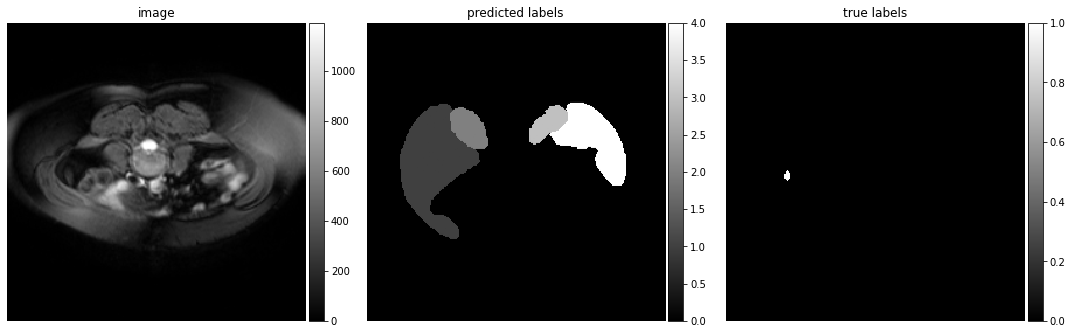

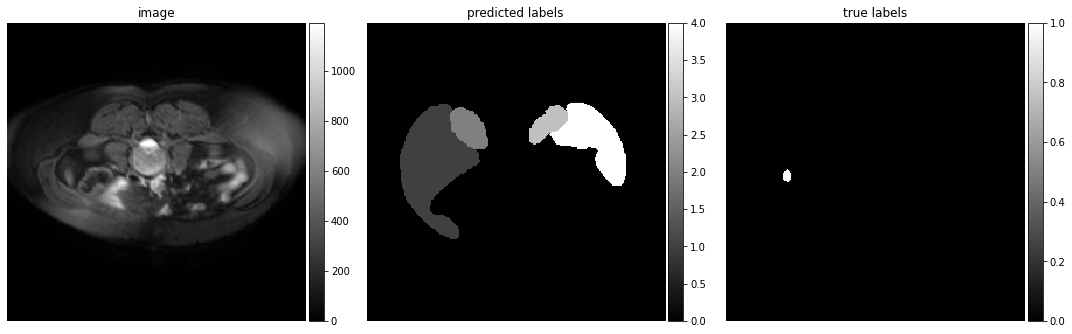

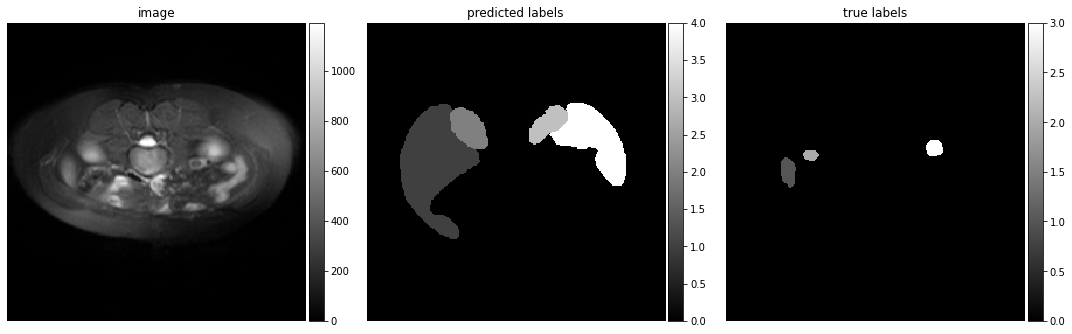

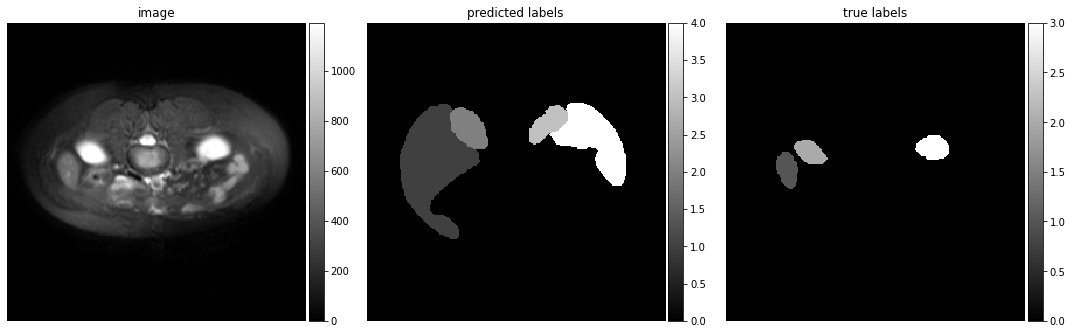

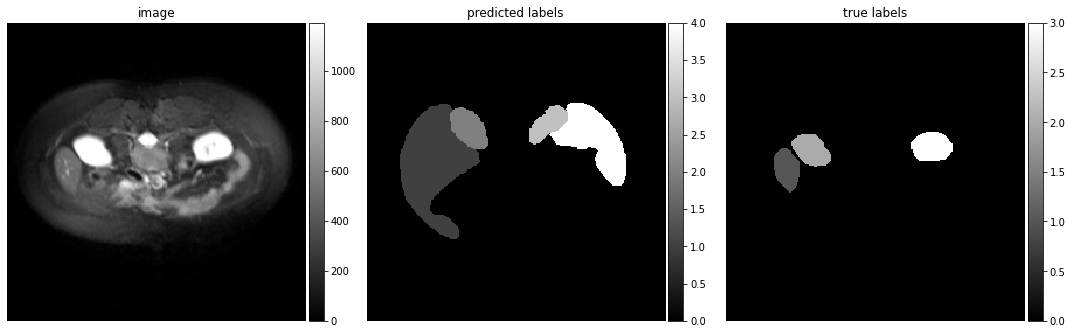

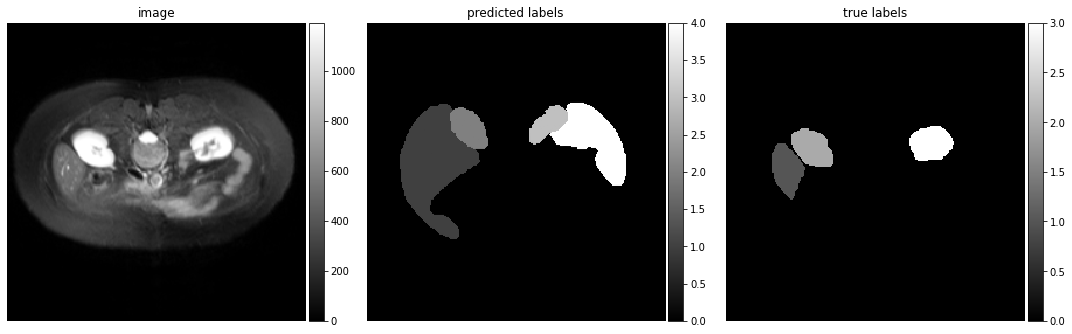

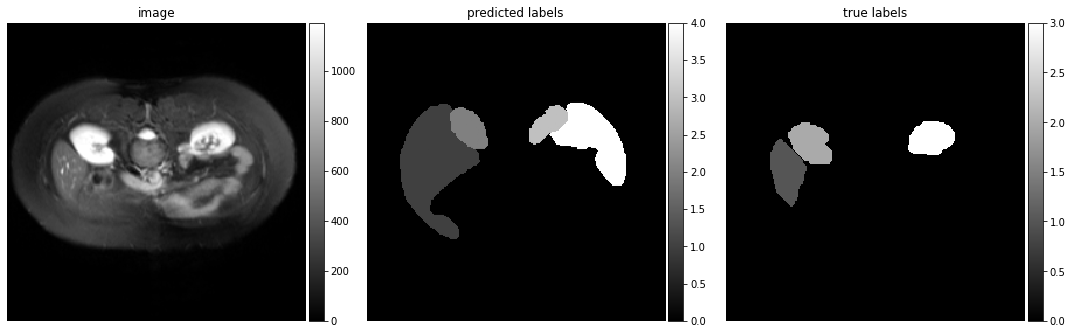

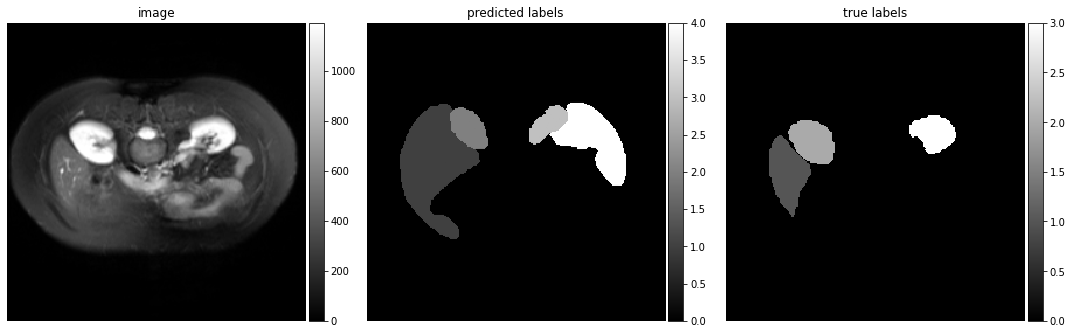

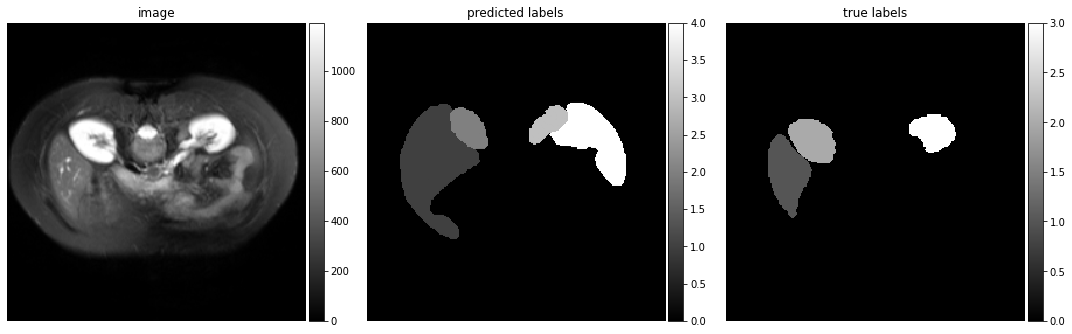

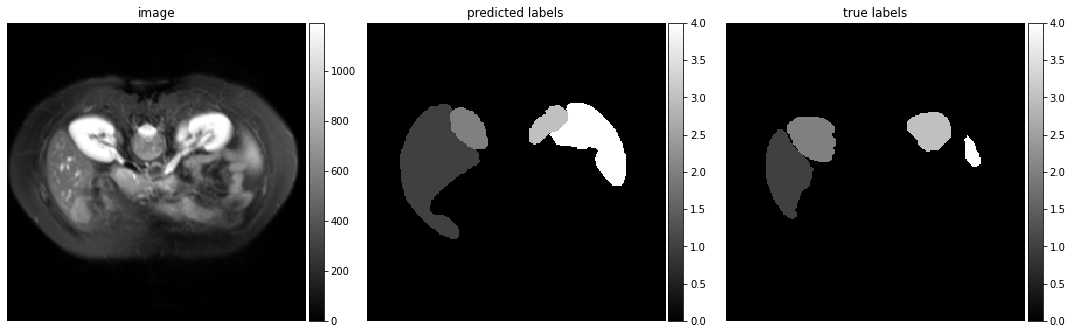

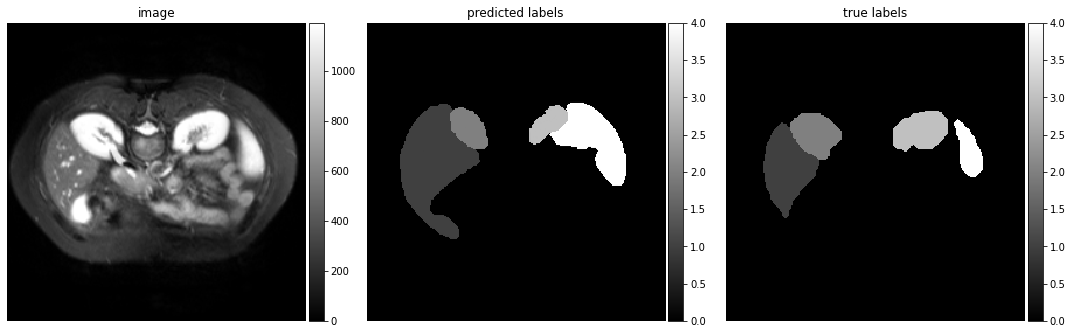

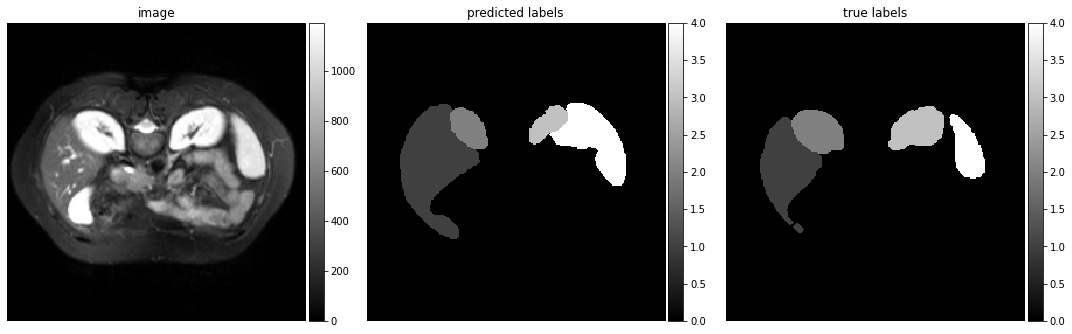

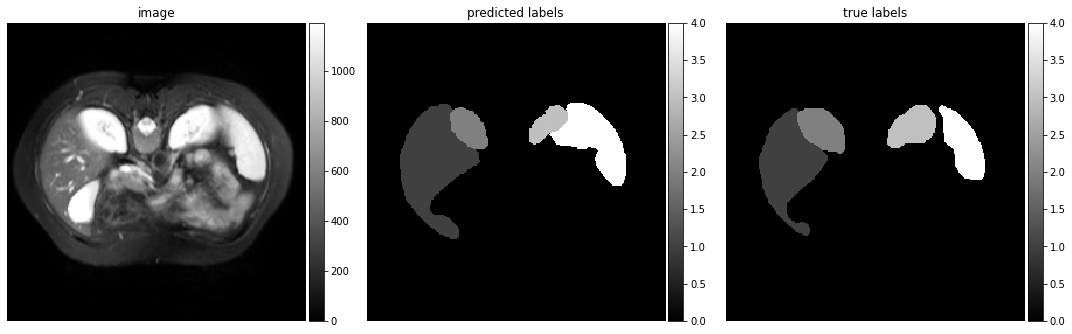

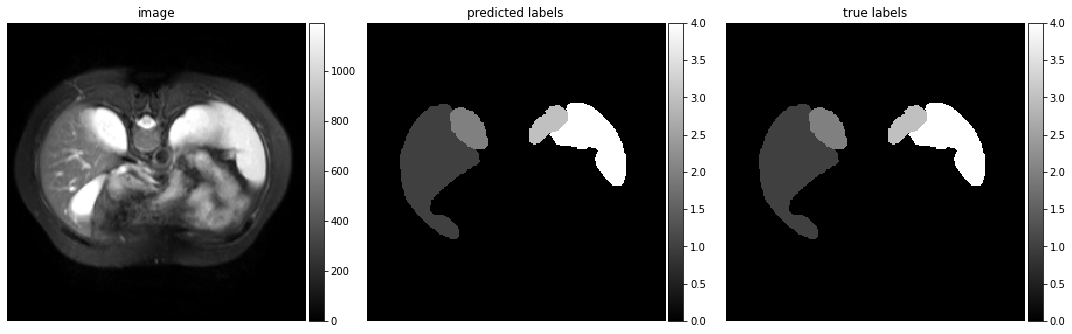

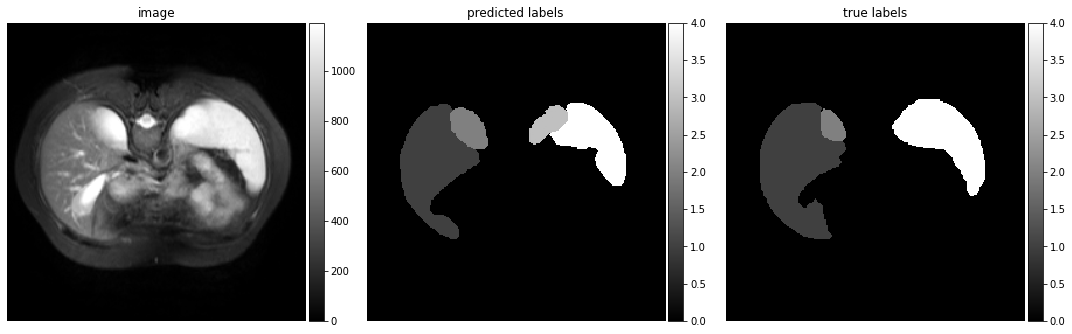

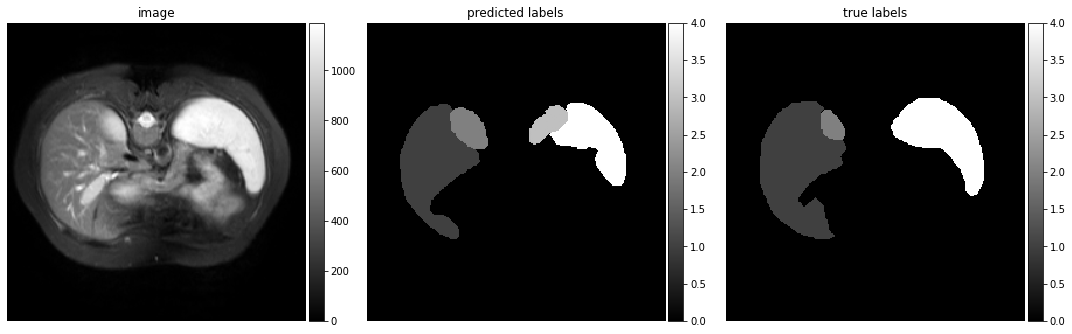

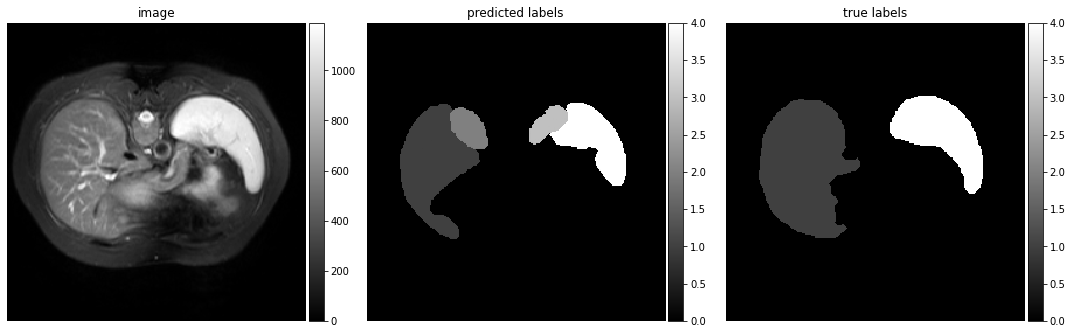

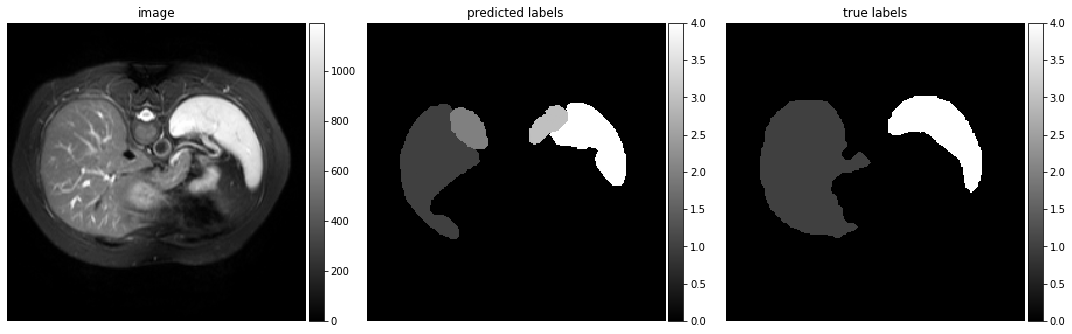

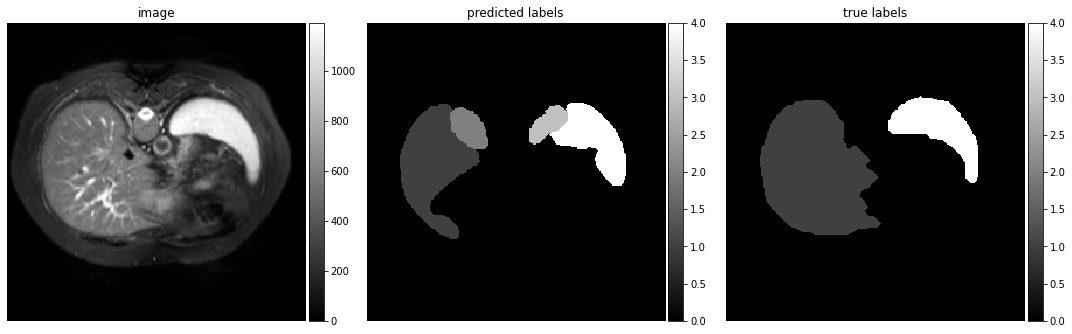

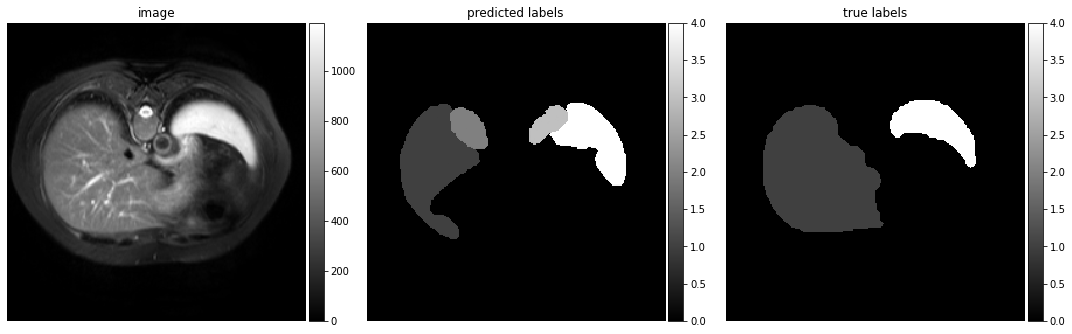

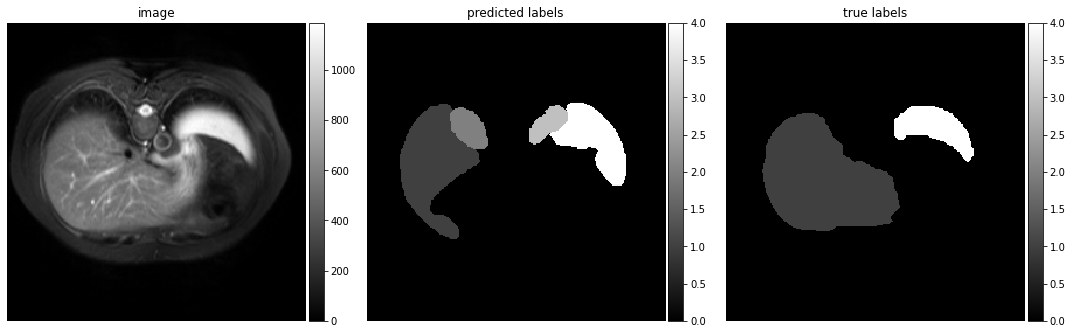

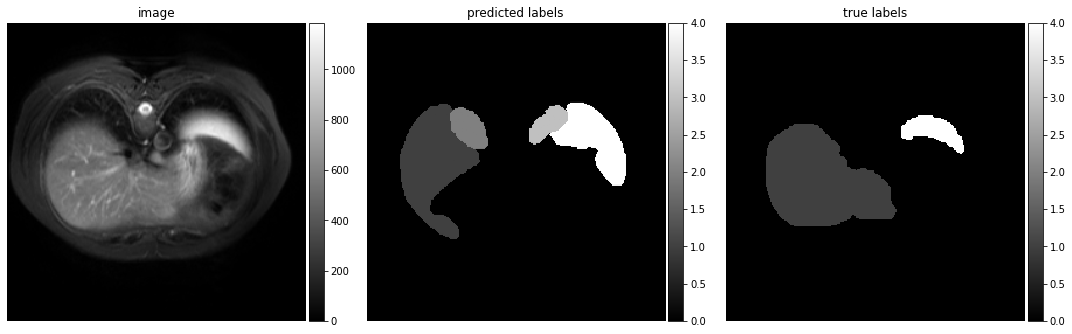

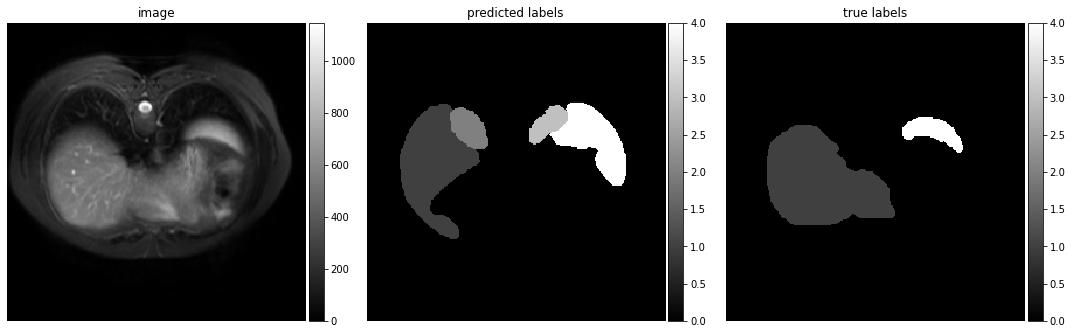

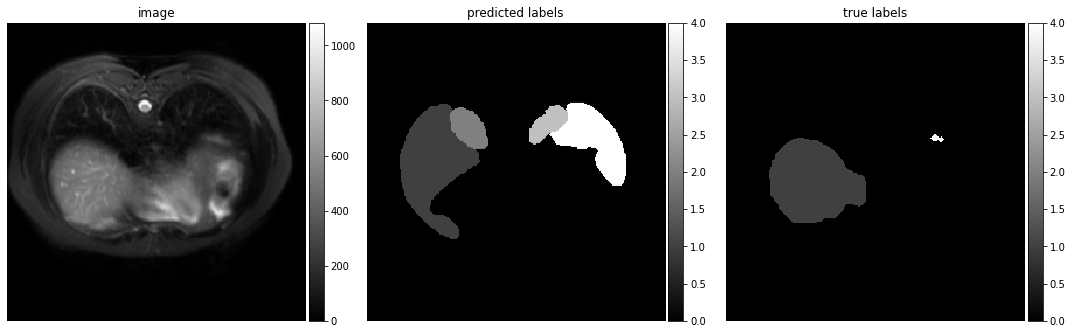

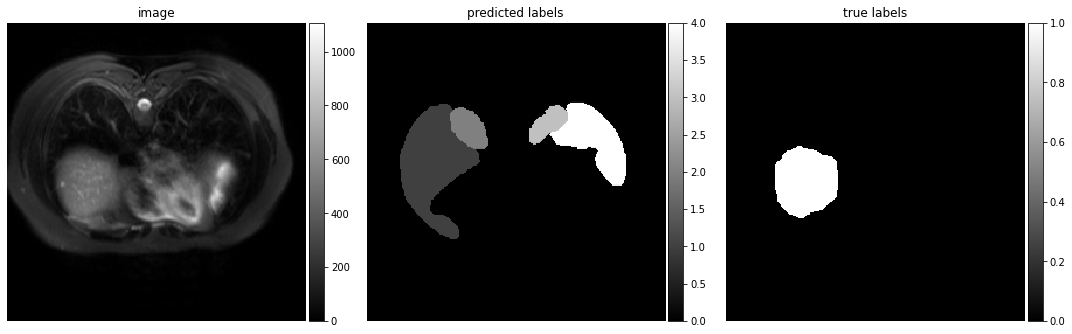

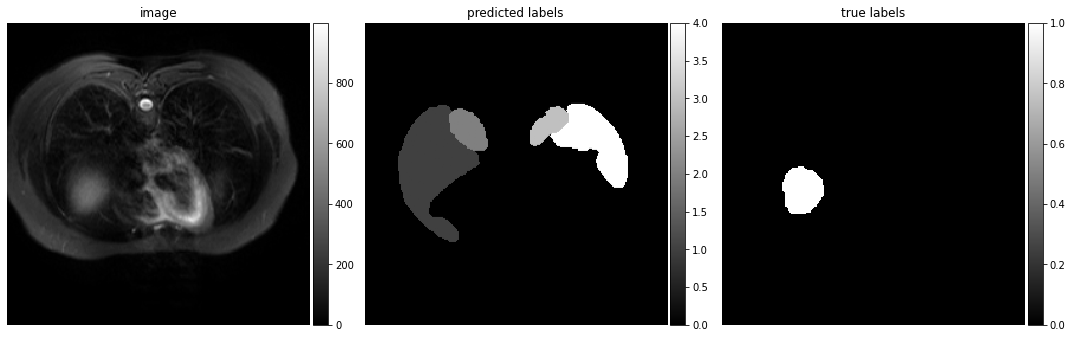

In [189]:
for i in range(len(targets)):
  ne.plot.slices([targets[i].cpu().numpy().squeeze(), output_labels[i].cpu().numpy().squeeze(), test_patient.labels[i]], titles=['image', 'predicted labels', 'true labels'], cmaps=['gray'], do_colorbars=True)

6.   Take the dice score between the propagated labels and the actual labels of slices. Report them one by one. 

In [190]:
dices = []
for i in range(len(targets)):
    dice = -Dice().loss((output_labels[i:i+1]>0).cpu().float(), torch.tensor(test_patient.labels[i:i+1] > 0, dtype=torch.float32))
    dices.append(dice.item())
    print(dice)  

tensor(0.0023)
tensor(0.0041)
tensor(0.0389)
tensor(0.0959)
tensor(0.1406)
tensor(0.1884)
tensor(0.2228)
tensor(0.2624)
tensor(0.2739)
tensor(0.3204)
tensor(0.4175)
tensor(0.4908)
tensor(0.5345)
tensor(0.6048)
tensor(0.5550)
tensor(0.5437)
tensor(0.5131)
tensor(0.4850)
tensor(0.4675)
tensor(0.4387)
tensor(0.3993)
tensor(0.3005)
tensor(0.2809)
tensor(0.1339)
tensor(0.0919)
tensor(0.0311)


Take the average of those. Report this number as the final metric of evaluation of your model.

In [191]:
print("Dice Score Test time : " + str(np.mean(dices)))

Dice Score Test time : 0.3014605971984565
